# Analyze simulation
adopted from [buffet_oat15](https://github.com/JanisGeise/buffet_oat15/tree/jgeise) to quickly post-process and assess a single steady-state simulation

In [1]:
import torch as pt
import sys
from glob import glob
from os import environ, system
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shutil import copytree, rmtree

from os import makedirs
import pandas as pd
from os.path import join, exists
from flowtorch.data import CSVDataloader

environ["airfoil_shape_optimization"] = ".."
sys.path.insert(0, environ["airfoil_shape_optimization"])

from airfoil_shape_optimization.generate_airfoil import AirfoilGenerator
from utils import load_yplus, load_force_coeffs, compute_camber_line, load_residuals, load_optimization_log, load_polar_files

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [2]:
# flow quantities
u_inf = 20
p_inf = 0
rho_inf = 1

# chord length
chord = 0.15

# use latex fonts
plt.rcParams.update({"text.usetex": True, "figure.dpi": 360, "text.latex.preamble": r"\usepackage{xcolor}"})

# use default color cycle
color = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

# use these linestyles
ls = ["-", "--", "-.", ":"]

In [3]:
# define load and save path
load_dir = join("..", "run", "test_polar_run", "new_OF_weighting")

save_dir = join("..", "run", "test_polar_run", "new_OF_weighting", "plots")
cases = ["kOmegaSSTLM", "kOmegaSST"]
legend = [r"$k-\omega-$SST, $\gamma-Re_\theta$", r"$k-\omega-$SST"]

# for which AoA should the quantities be plotted
which_alpha = "alpha_{:.6f}".format(0)

# create plot directory
if not exists(save_dir):
    makedirs(save_dir)

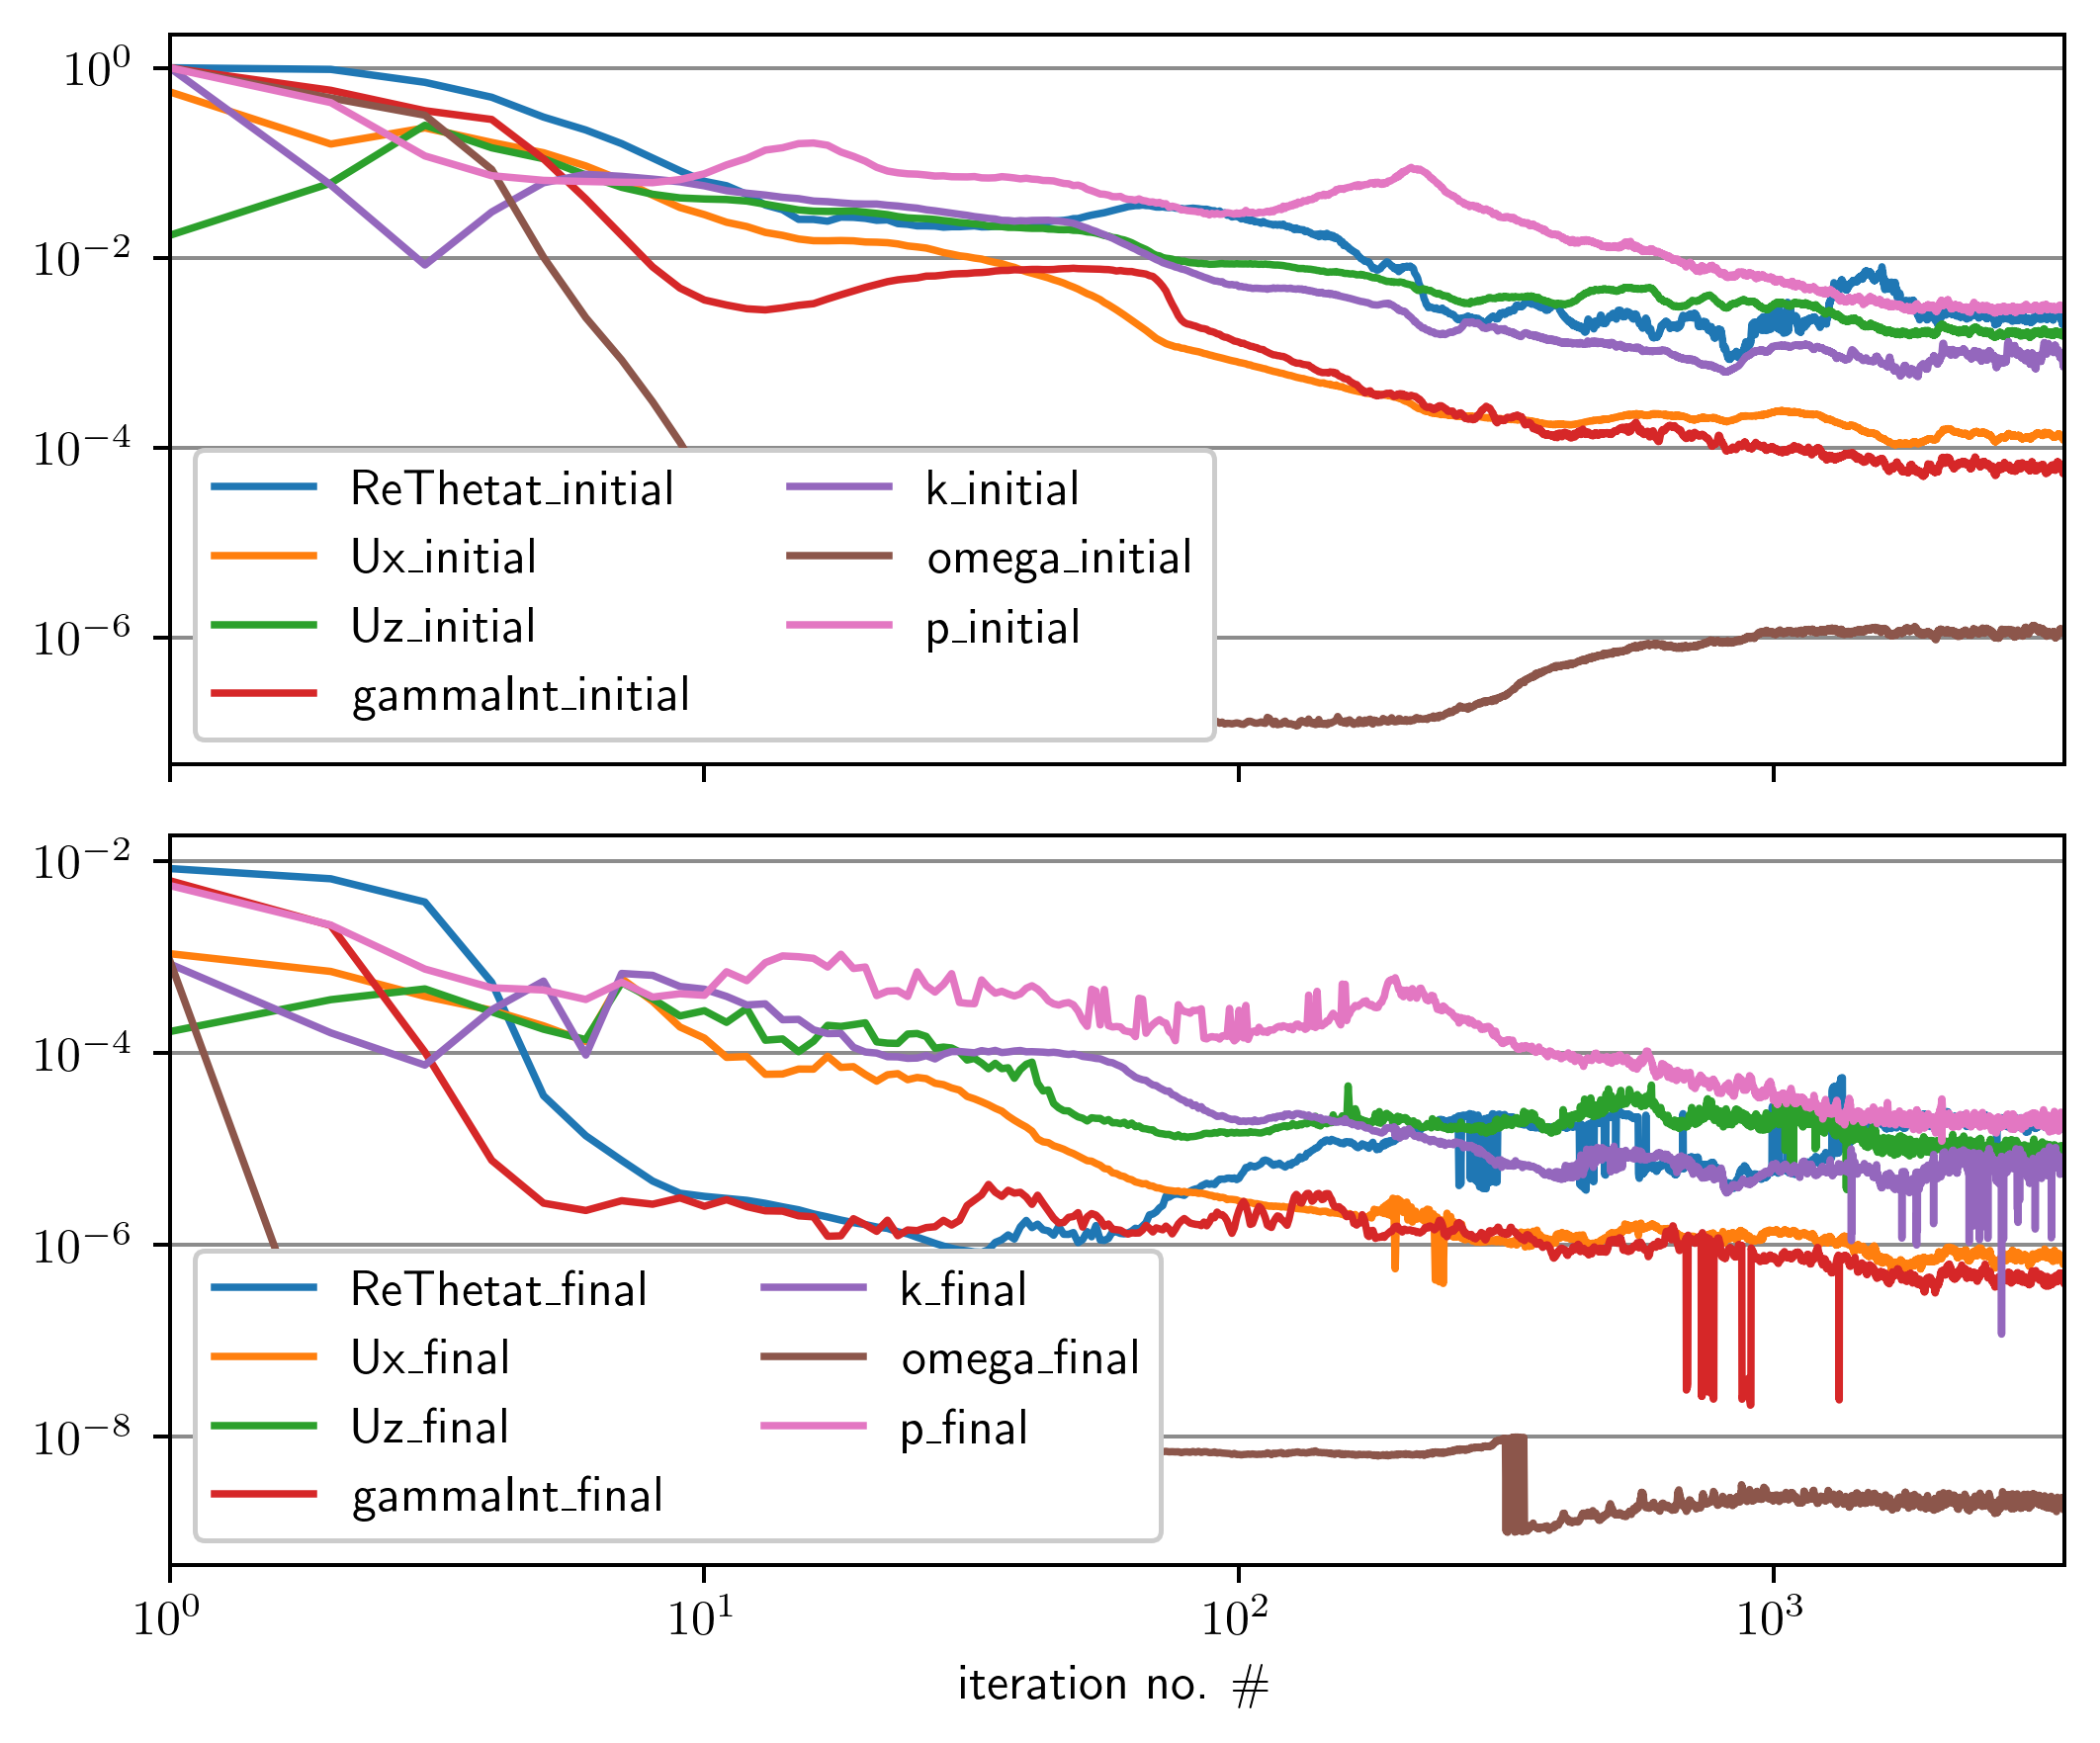

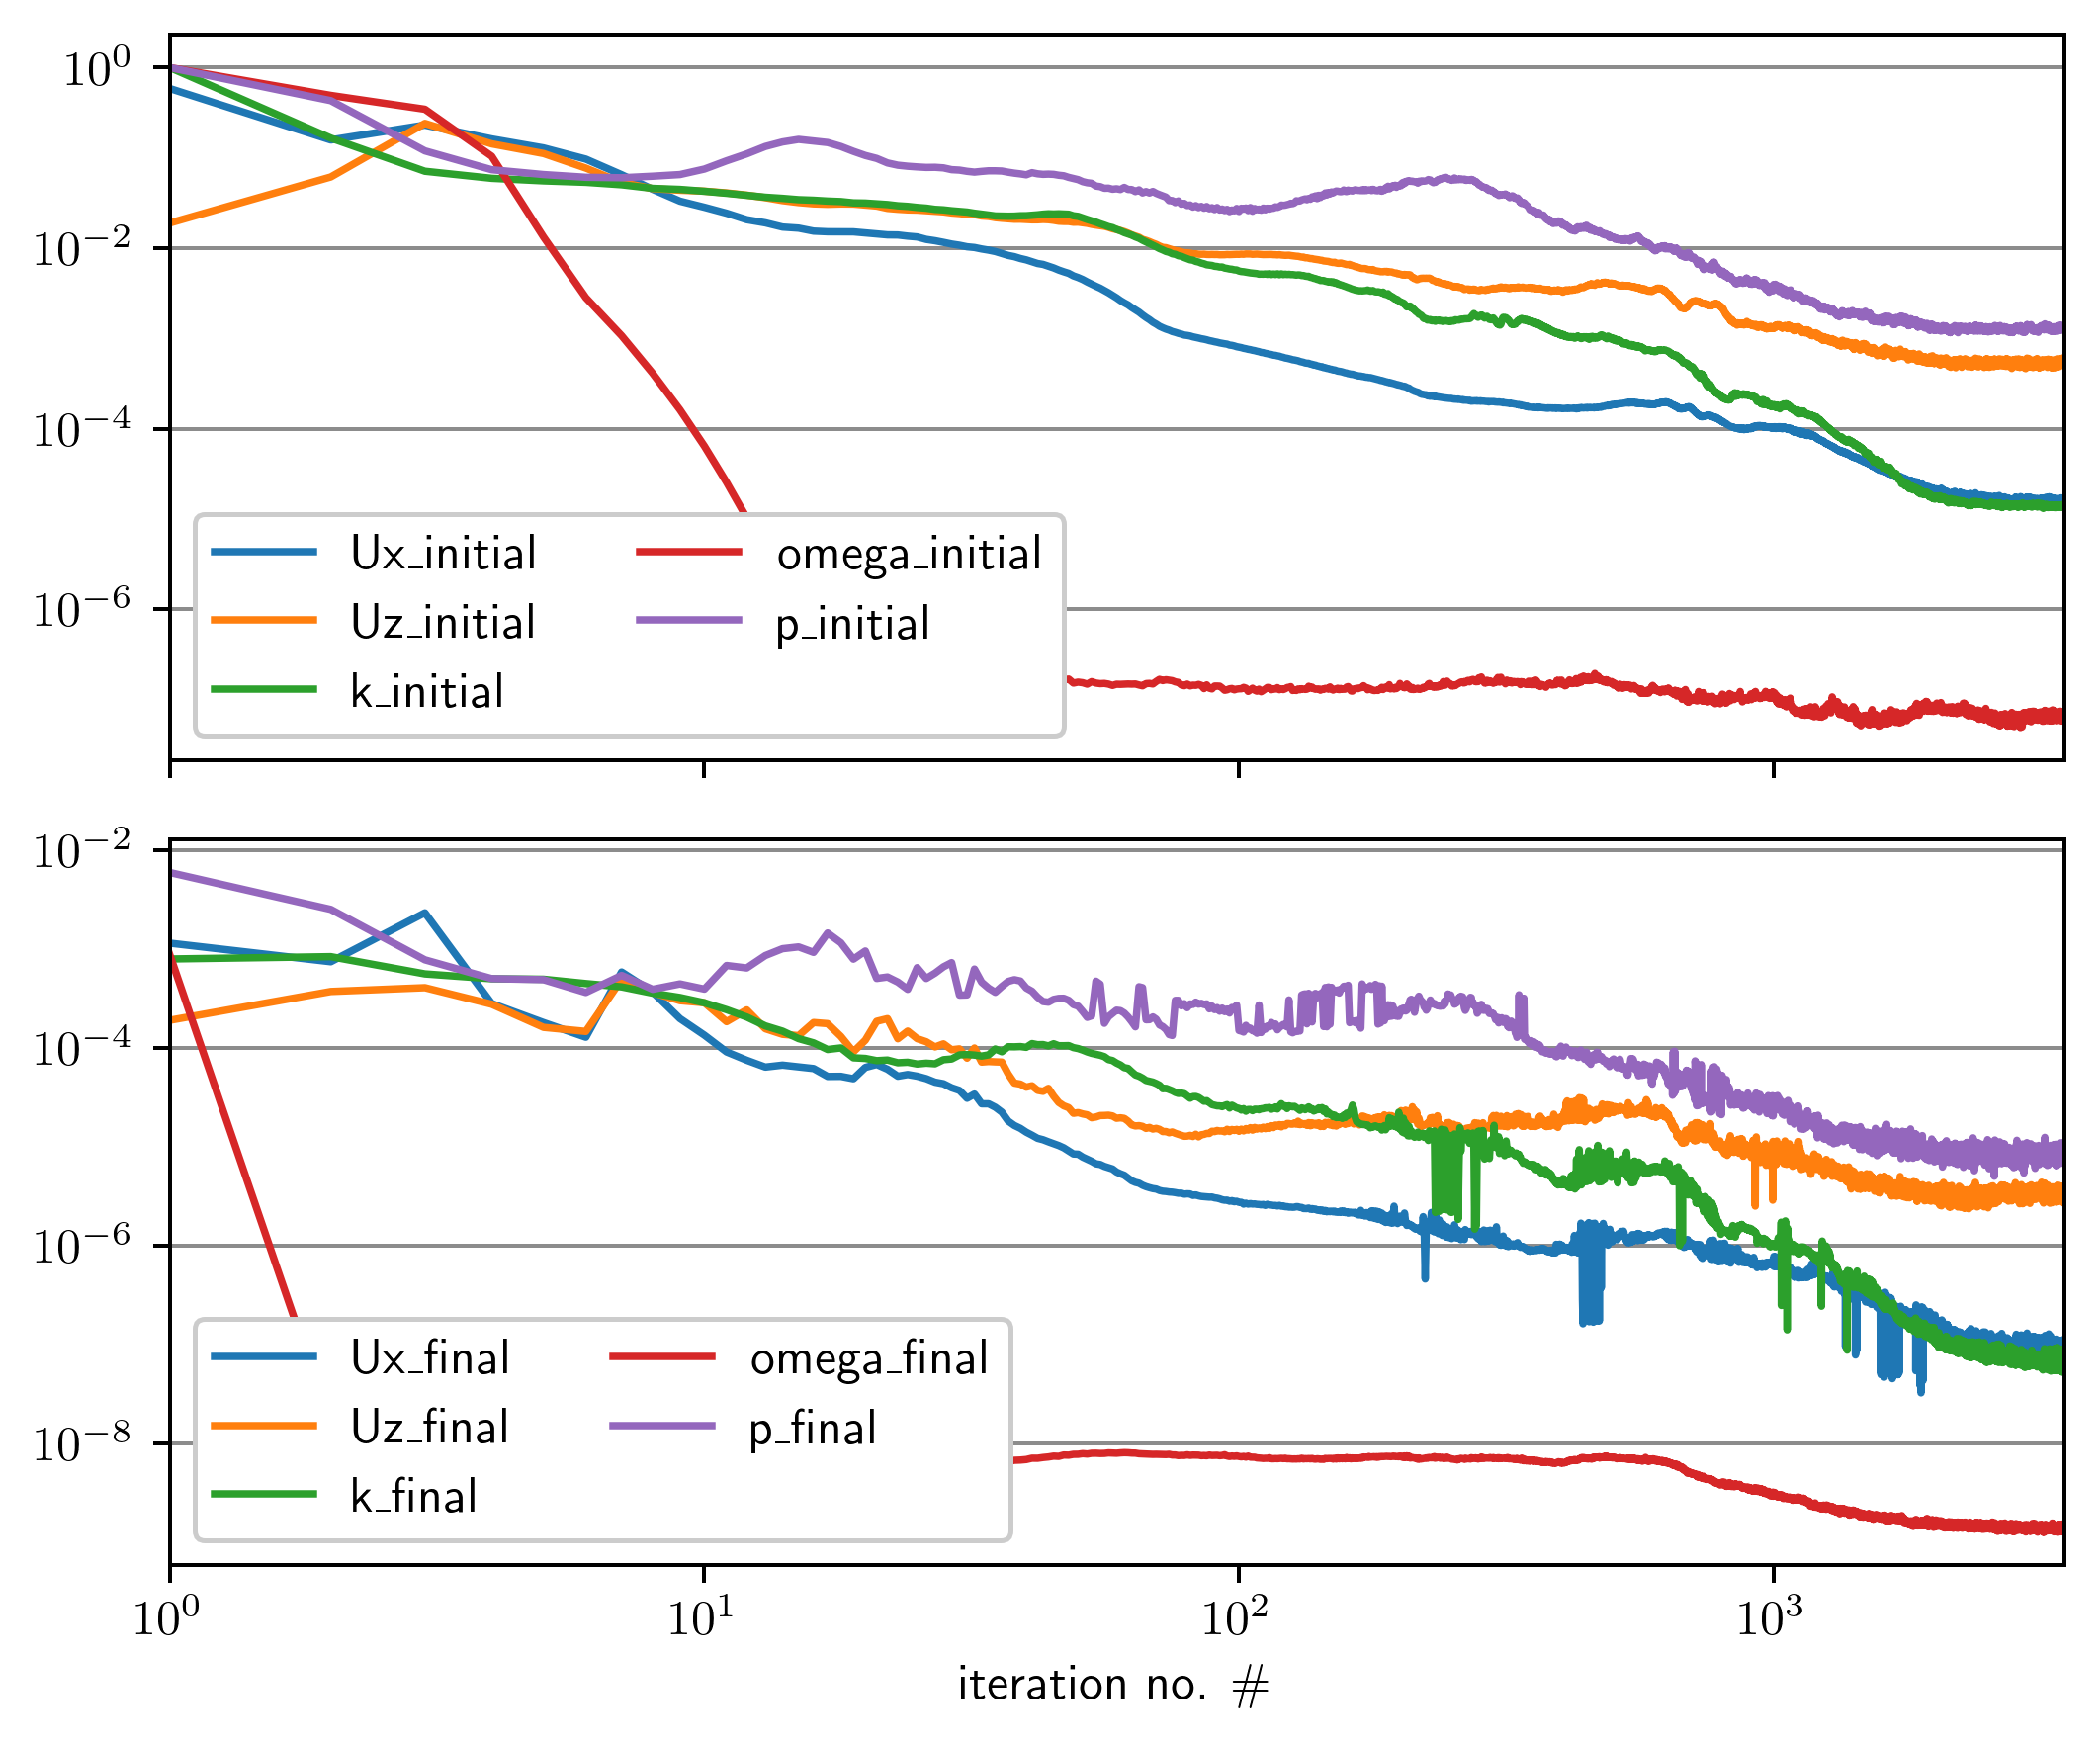

In [4]:
# load residuals
residuals = [load_residuals(join(load_dir, c, "validation_run"), which_alpha) for c in cases]

# plot residuals
for c in range(len(cases)):
    fig, ax = plt.subplots(2, 1, figsize=(6, 5), sharex="col")
    for k in residuals[c].keys():
        if k.endswith("_initial") and not k == "Time":
            ax[0].plot(residuals[c]["Time"], residuals[c][k], label=k)
    
        elif k.endswith("_final") and not k == "Time":
            ax[1].plot(residuals[c]["Time"], residuals[c][k], label=k)
    
    for i in range(2):
        # ax[i].axvline(750, color="black", ls="--")
    
        ax[i].set_yscale("log")
        ax[i].set_xscale("log")
        ax[i].set_xlim(residuals[c]["Time"].min(), residuals[c]["Time"].max())
        ax[i].legend(ncols=2, loc="lower left", facecolor="white", framealpha=1)
    
        ax[i].grid(visible=True, which="major", linestyle="-", alpha=0.45, color="black", axis="y")
        ax[i].minorticks_on()
        ax[i].tick_params(axis="x", which="minor", bottom=False)
        ax[i].grid(visible=True, which="minor", linestyle="--", alpha=0.35, color="black", axis="y")
    
    ax[-1].set_xlabel(r"iteration no. $\#$")
    fig.tight_layout()
    plt.savefig(join(save_dir, f"residuals_vs_iterations_case{c}_{which_alpha}.png"))

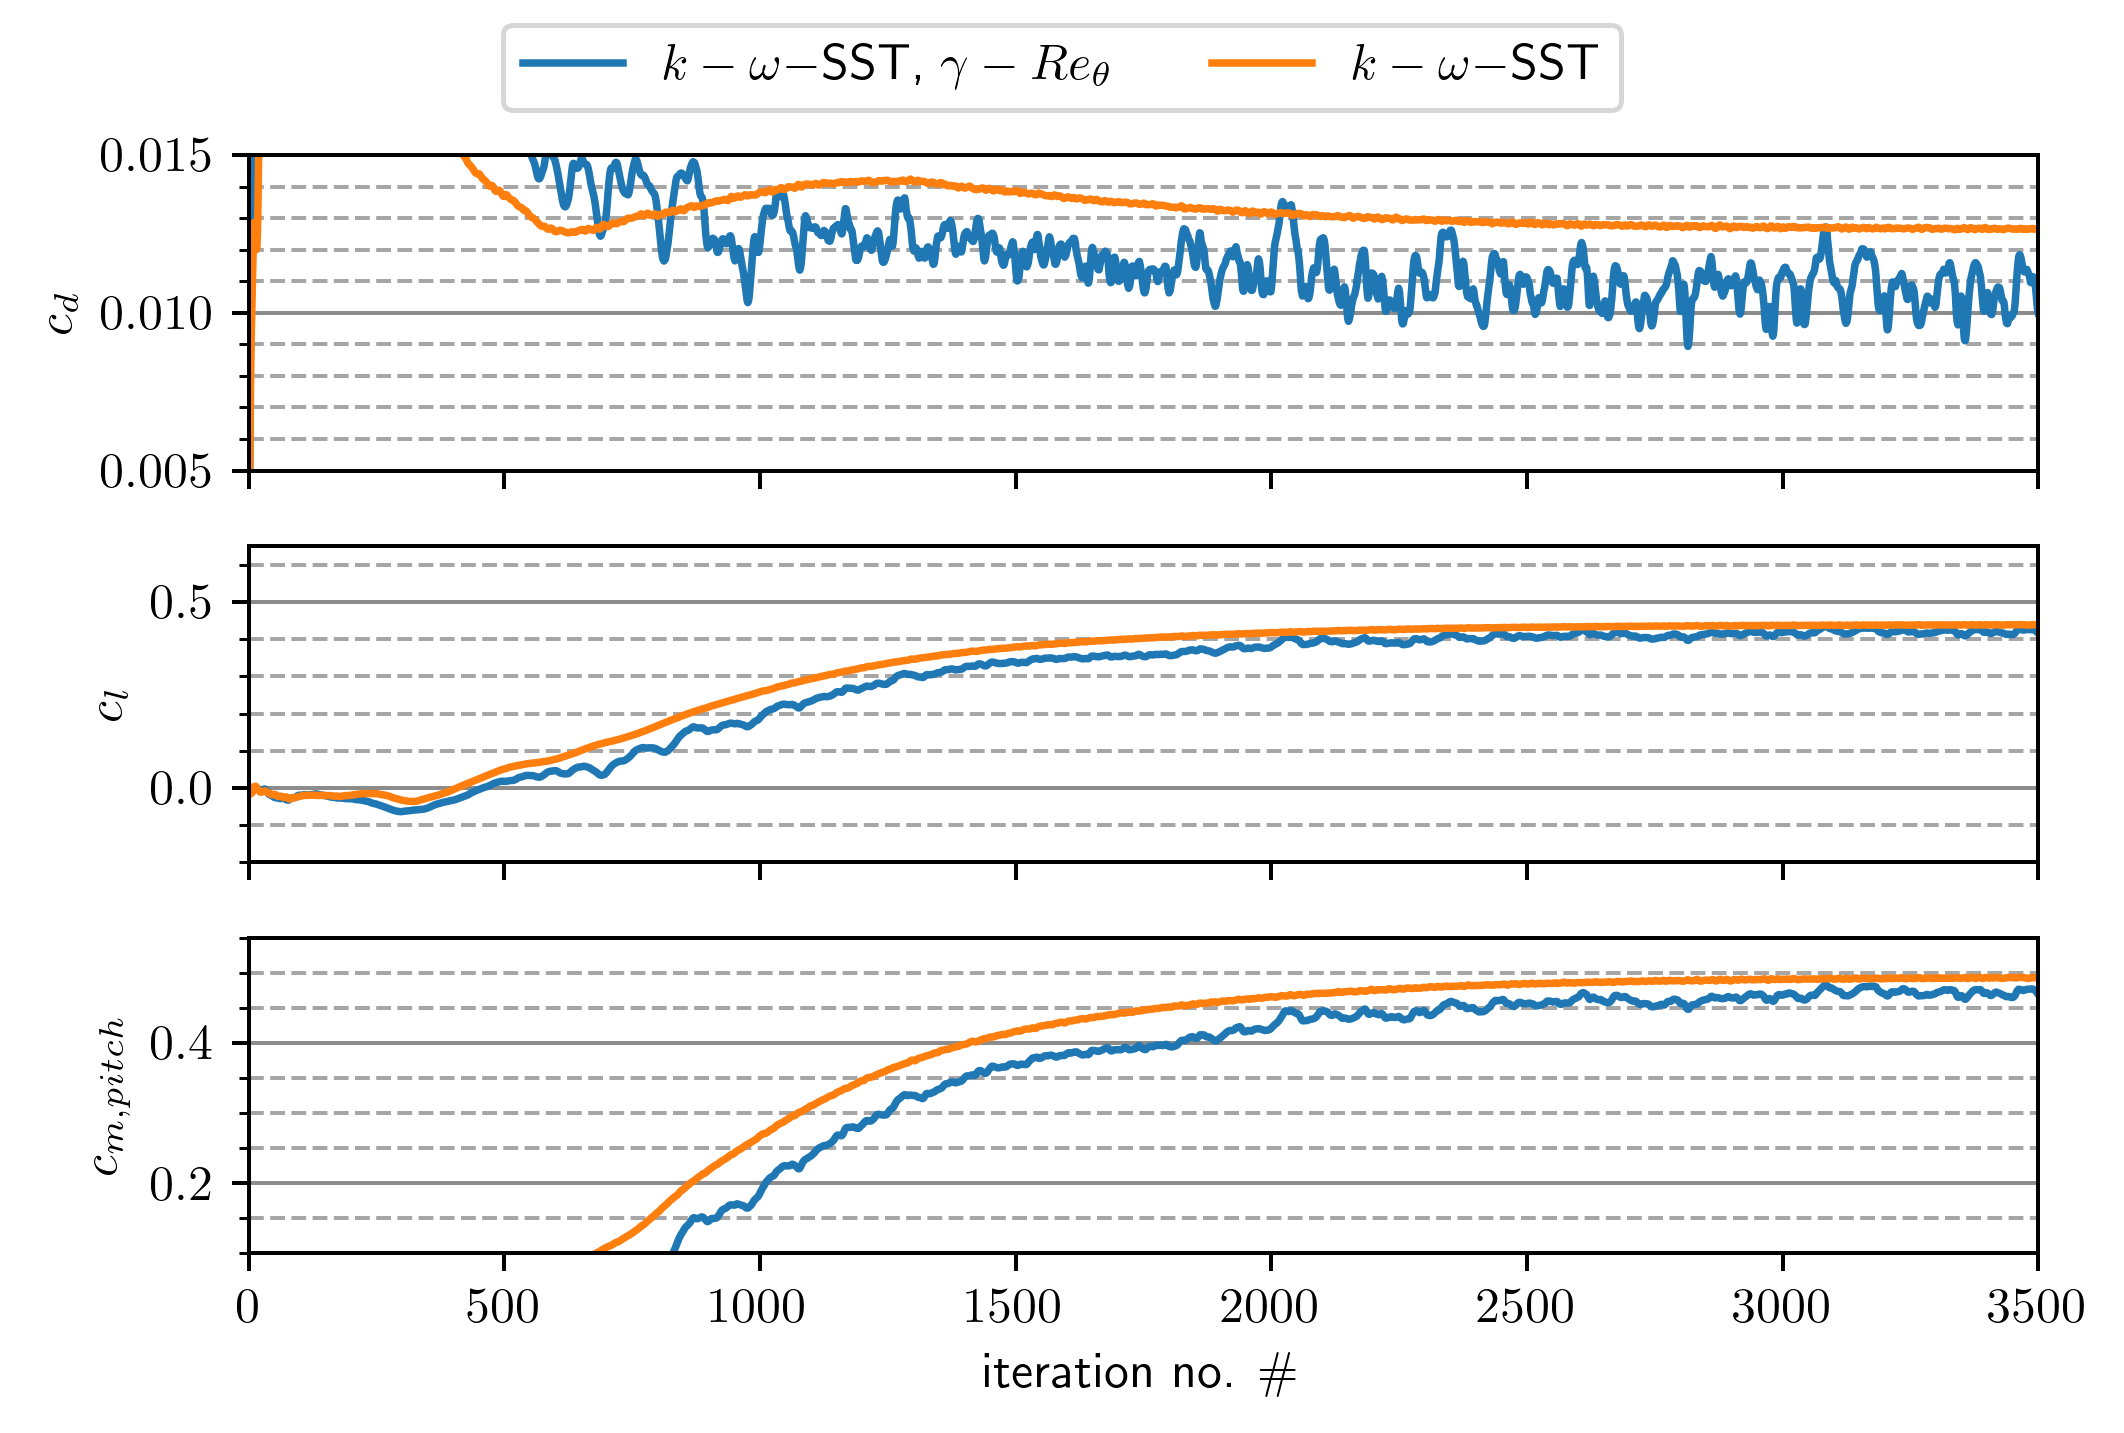

In [7]:
# check forces 
forces = [load_force_coeffs(join(load_dir, c, "validation_run"), which_alpha) for c in cases]

ls = ["-"] * len(forces)

# use default color cycle
color = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

fig, ax = plt.subplots(3, 1, figsize=(6, 4), sharex="col")
for i in range(len(cases)):
    ax[0].plot(forces[i].t, forces[i].cx, label=legend[i], ls=ls[i], color=color[i])
    ax[1].plot(forces[i].t, forces[i].cy, ls=ls[i], color=color[i])
    ax[2].plot(forces[i].t, forces[i].cm_pitch, ls=ls[i], color=color[i])

ax[0].set_ylim(0.005, 0.015)
ax[1].set_ylim(-0.2, 0.65)
ax[2].set_ylim(0.1, 0.55)
ax[0].set_ylabel(r"$c_d$")
ax[1].set_ylabel(r"$c_l$")
ax[2].set_ylabel(r"$c_{m, pitch}$")
ax[-1].set_xlabel(r"iteration no. $\#$")
ax[-1].set_xlim(0, forces[0].t.max())

fig.tight_layout()
for i in range(3):
    ax[i].grid(visible=True, which="major", linestyle="-", alpha=0.45, color="black", axis="y")
    ax[i].minorticks_on()
    ax[i].tick_params(axis="x", which="minor", bottom=False)
    ax[i].grid(visible=True, which="minor", linestyle="--", alpha=0.35, color="black", axis="y")

fig.legend(ncol=3, loc="upper center")
fig.subplots_adjust(top=0.9)
plt.savefig(join(save_dir, f"comparison_coefficients_vs_t_{which_alpha}.png"))

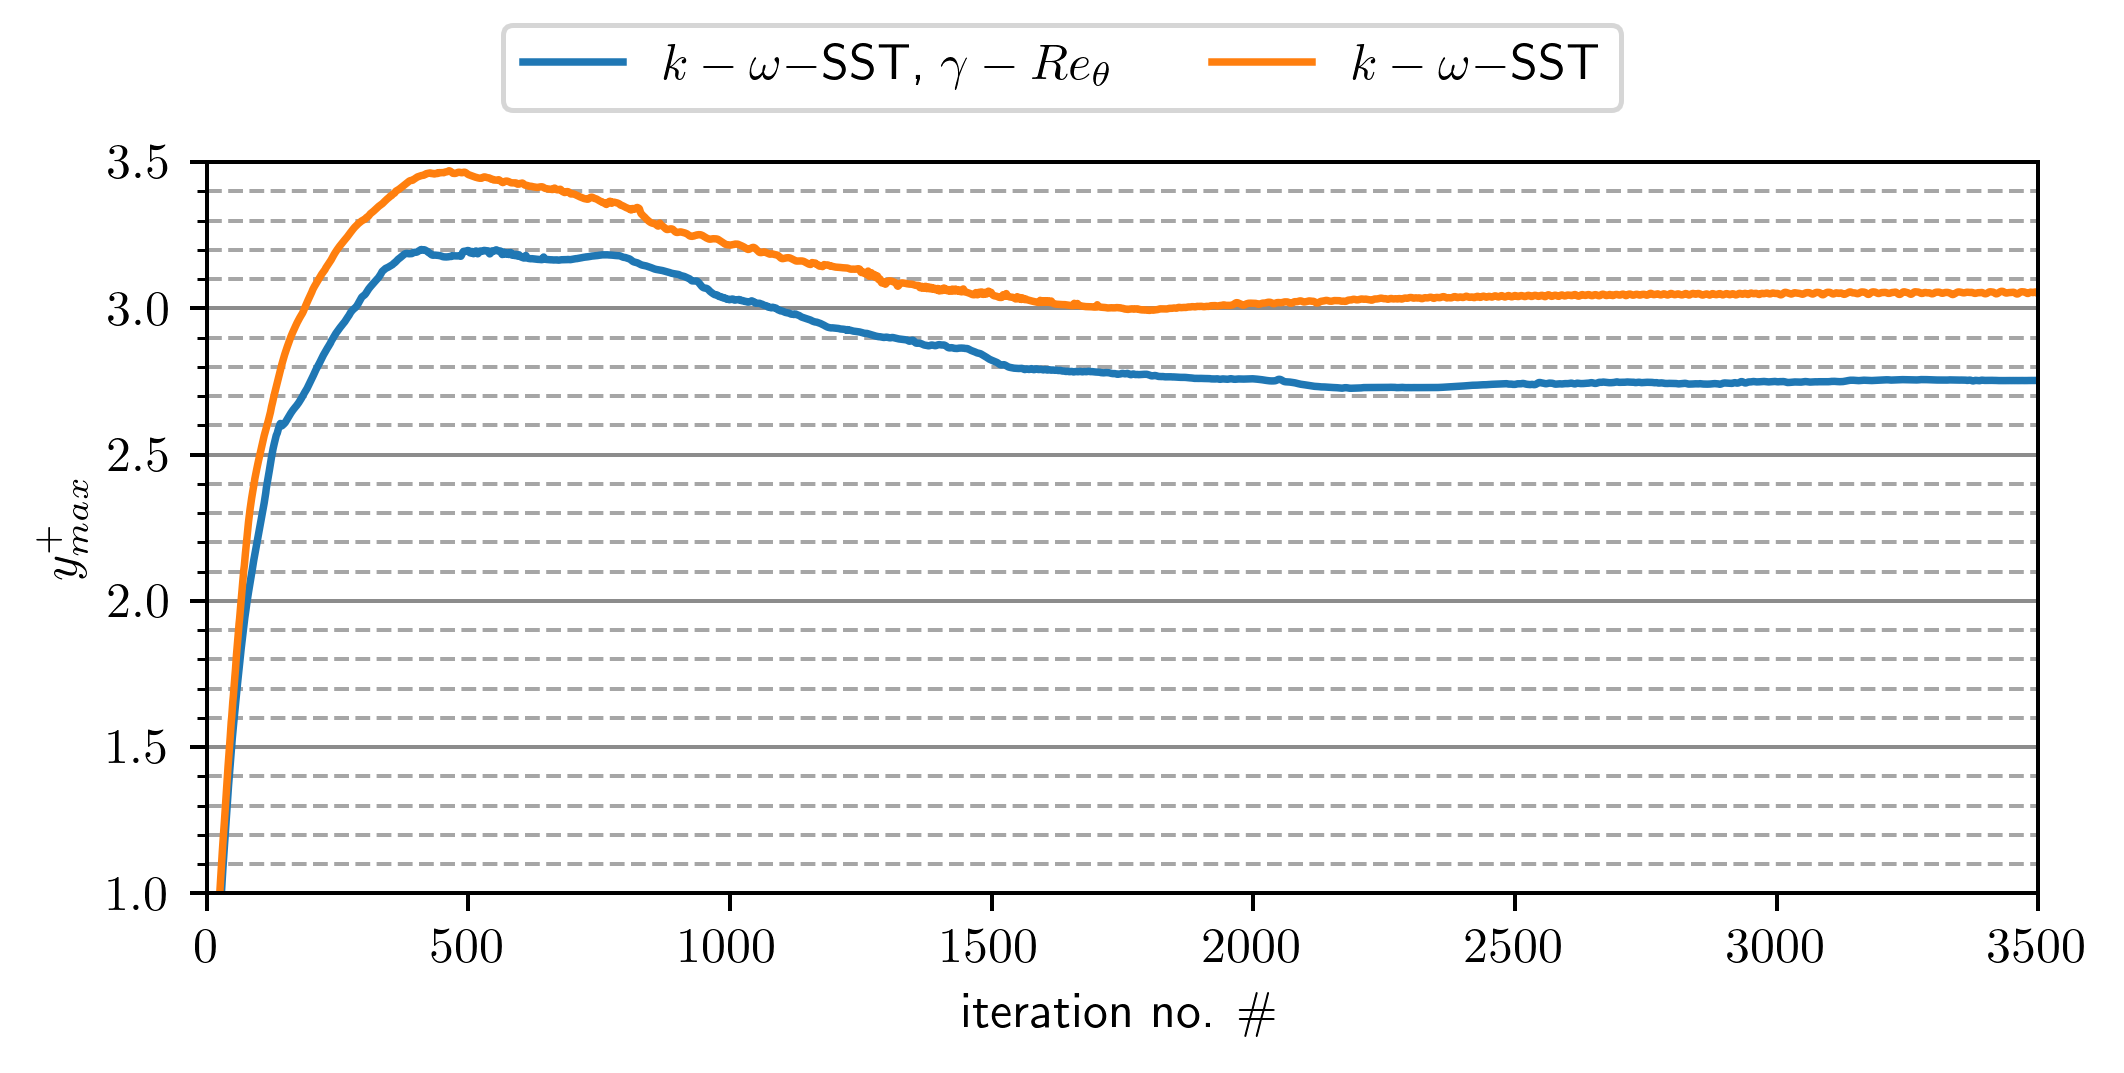

In [8]:
# plot max y+ vs. time
y_plus = [load_yplus(join(load_dir, c, "validation_run"), which_alpha) for c in cases]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
for i in range(len(cases)):
    ax.plot(y_plus[i].t, y_plus[i].yPlus_max, label=legend[i], ls=ls[i])
        
ax.set_xlabel(r"iteration no. $\#$")
ax.set_xlim(0, forces[0].t.max())
ax.set_ylabel("$y^+_{max}$")
ax.set_ylim(1, 3.5)
fig.tight_layout()
ax.grid(visible=True, which="major", linestyle="-", alpha=0.45, color="black", axis="y")
ax.minorticks_on()
ax.tick_params(axis="x", which="minor", bottom=False)
ax.grid(visible=True, which="minor", linestyle="--", alpha=0.35, color="black", axis="y")
fig.legend(ncol=3, loc="upper center")
fig.subplots_adjust(top=0.86)
plt.savefig(join(save_dir, f"comparison_yPlus_max_vs_t_{which_alpha}.png"))

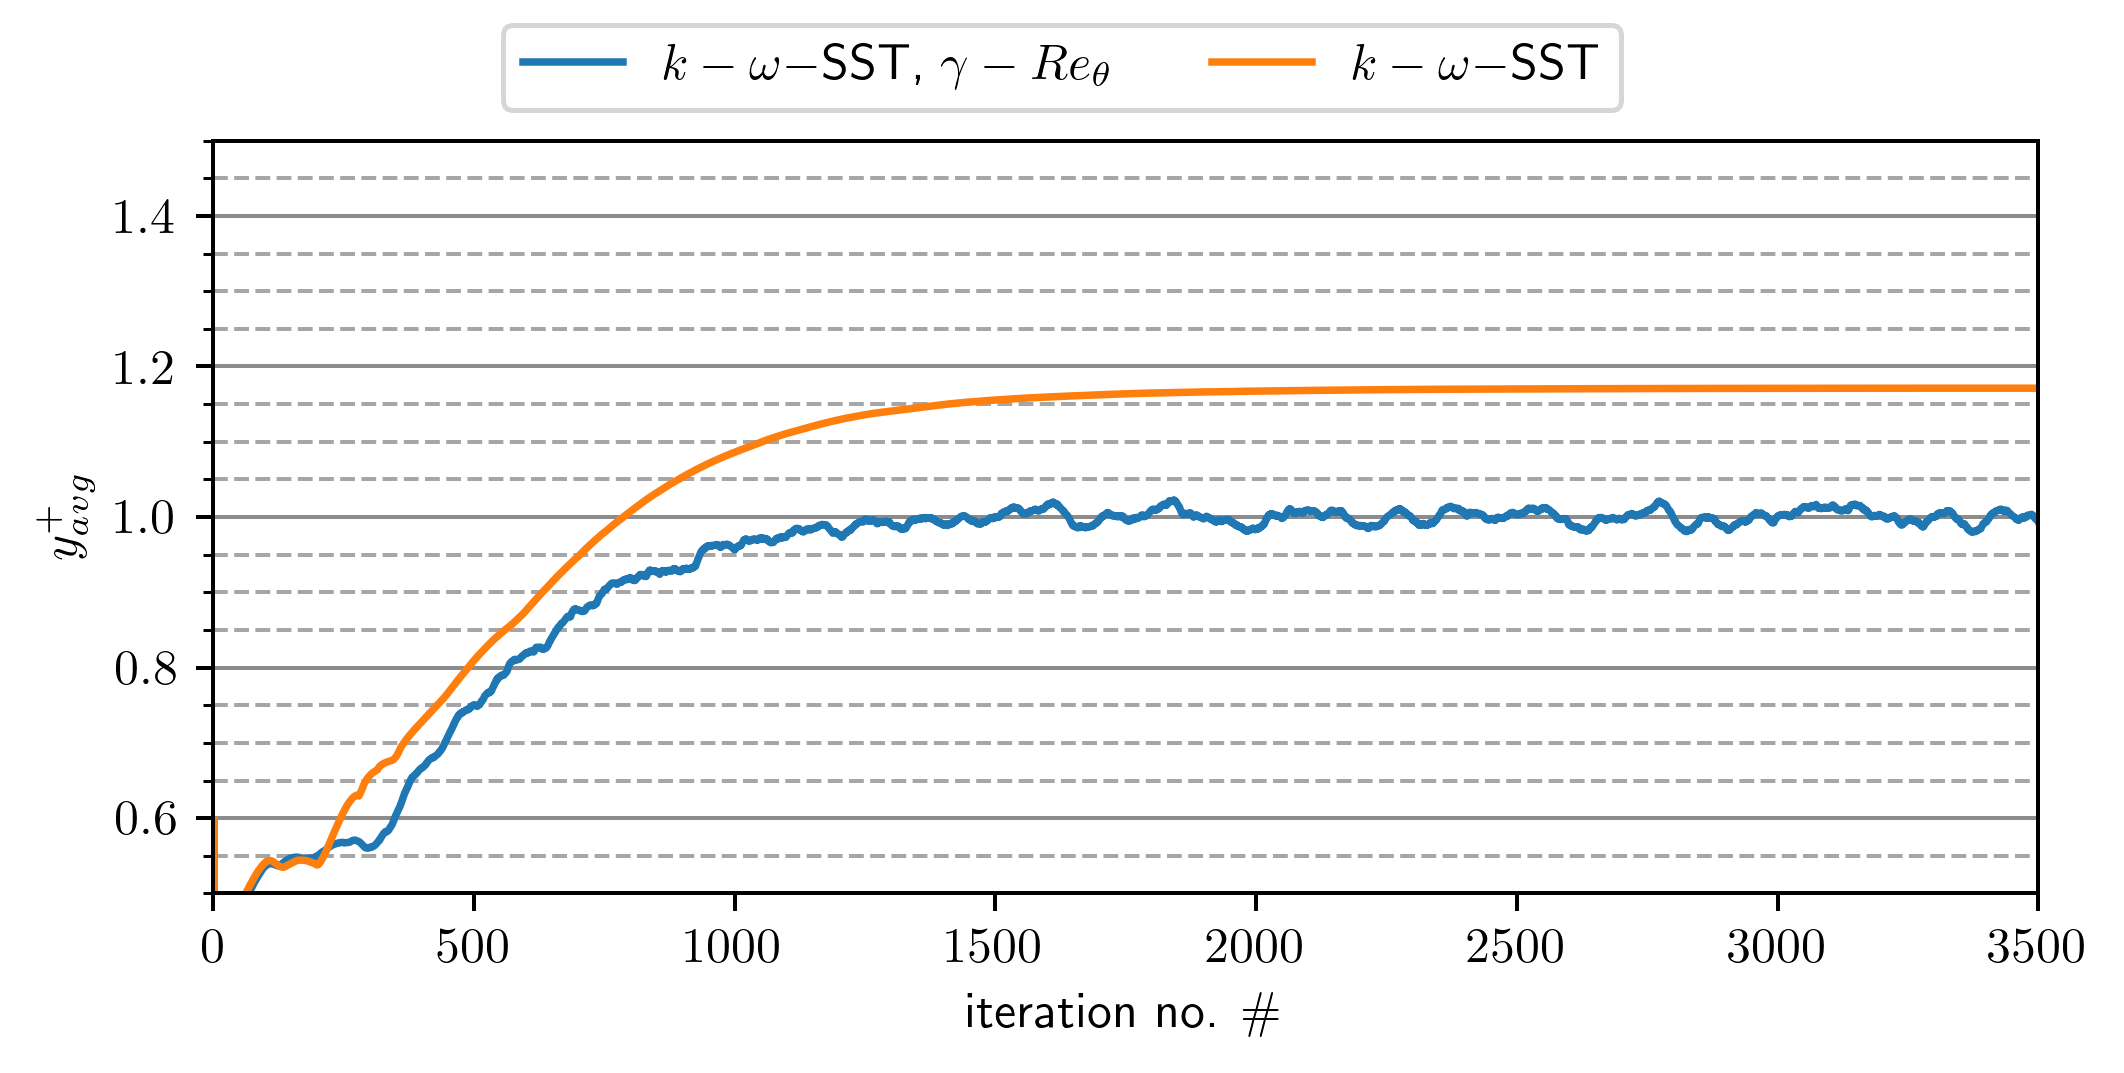

In [9]:
# plot avg. y+ vs. time
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
for i in range(len(cases)):
    ax.plot(y_plus[i].t, y_plus[i].yPlus_avg, label=legend[i], ls=ls[i])
        
ax.set_xlabel(r"iteration no. $\#$")
ax.set_xlim(0, forces[0].t.max())
ax.set_ylabel("$y^+_{avg}$")
ax.set_ylim(0.5, 1.5)
fig.tight_layout()
ax.grid(visible=True, which="major", linestyle="-", alpha=0.45, color="black", axis="y")
ax.minorticks_on()
ax.tick_params(axis="x", which="minor", bottom=False)
ax.grid(visible=True, which="minor", linestyle="--", alpha=0.35, color="black", axis="y")
fig.legend(ncol=3, loc="upper center")
fig.subplots_adjust(top=0.88)
plt.savefig(join(save_dir, f"comparison_yPlus_avg_vs_t_{which_alpha}.png"))

In [10]:
x, z, cp, camber = [], [], [], []

# TODO: mv to fct
airfoil_generator = AirfoilGenerator(x_stop=0.15)

for i, c in enumerate(cases):
    # TODO: not working if dir name can't be converted to float so make copy from the target dir ass work-around for now
    copytree(join(load_dir, c, "validation_run", "postProcessing", "surface", which_alpha), 
             join(load_dir, c, "validation_run", "postProcessing", "surface_tmp", which_alpha.split("_")[-1]), dirs_exist_ok=True)
    
    loader = CSVDataloader.from_foam_surface(join(load_dir, c, "validation_run", "postProcessing", "surface_tmp"),
                                                 f"p_airfoil.raw")

    x_temp = loader.vertices[:, 0]
    z_temp = loader.vertices[:, 2]

    # TODO: mv to fct
    final_params = pt.load(join(load_dir, c, "results_final_parameters.pt"), weights_only=False)[0]
    
    x_af, y_af = airfoil_generator.generate_airfoil(final_params["N1"], final_params["N2"], final_params["KR"],
                                                    final_params["f_max"], final_params["xf"],
                                                    final_params["t_max"], write_file=False)
    x_ss, y_ss = x_af[:x_af.size(0)//2+1], y_af[:x_af.size(0)//2+1]
    x_ps, y_ps = x_af[x_af.size(0)//2:], y_af[x_af.size(0)//2:]
    _y_middle = y_ps + (reversed(y_ss) - y_ps) / 2

    # interpolate onto actual x-coordinates
    camber_interp = interp1d(x_ps, _y_middle, kind='linear', fill_value='extrapolate')
    camber_line = pt.tensor(camber_interp(x_temp.numpy()))

    # get all coordinates for suction and pressure side
    is_suction = z_temp > camber_line
    is_pressure = ~is_suction

    # TODO: work-around
    cp_temp = loader.load_snapshot("p", which_alpha.split("_")[-1])
    cp_suction = cp_temp[is_suction]
    cp_pressure = cp_temp[is_pressure]

    x_suction = x_temp[is_suction]
    z_suction = z_temp[is_suction]
    x_pressure = x_temp[is_pressure]
    z_pressure = z_temp[is_pressure]

    idx_suction = pt.argsort(x_suction, descending=True)
    x_suction = x_suction[idx_suction]
    z_suction = z_suction[idx_suction]
    cp_suction = cp_suction[idx_suction]

    idx_pressure = pt.argsort(x_pressure)
    x_pressure = x_pressure[idx_pressure]
    z_pressure = z_pressure[idx_pressure]
    cp_pressure = cp_pressure[idx_pressure]

    x_sorted = pt.cat([x_suction, x_pressure])
    z_sorted = pt.cat([z_suction, z_pressure])
    cp_sorted = pt.cat([cp_suction, cp_pressure])

    x.append(x_sorted)
    z.append(z_sorted)
    cp.append((cp_sorted - p_inf) / (0.5 * rho_inf * u_inf**2))
    # we interpolated the camber line at the same positions as x_ps
    camber.append([x_temp, camber_line])

    # remove tmp workaround
    rmtree(join(load_dir, c, "validation_run", "postProcessing", "surface_tmp"))

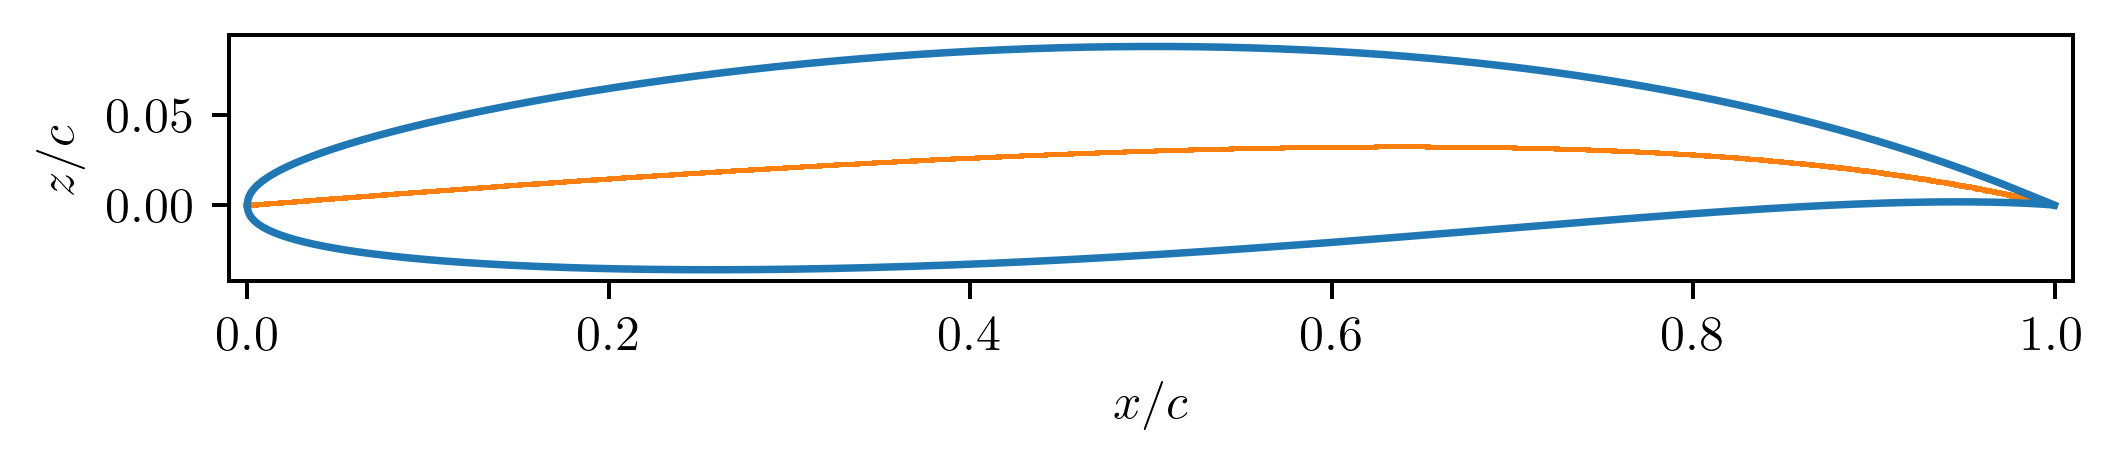

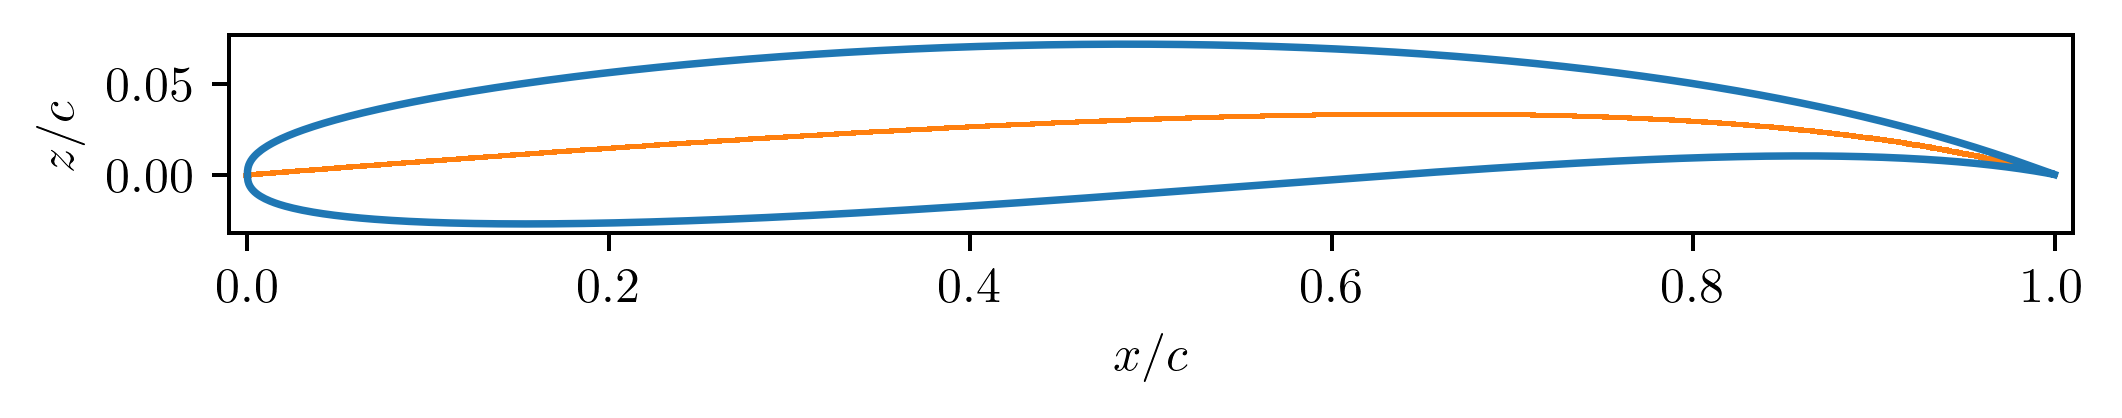

In [11]:
# test plot airfoil with computed camber line
for c in range(len(cases)):
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.plot(x[c] / chord, z[c] / chord, color=color[0])
    ax.scatter(camber[c][0] / chord, camber[c][1] / chord, color=color[1], marker="|", s=1)
    ax.set_aspect("equal")
    ax.set_xlabel("$x / c$")
    ax.set_ylabel("$z / c$")
    ax.set_xlim(-0.01, 1.01)
    fig.tight_layout()
    plt.savefig(join(save_dir, f"airfoil_case_{c}.png"))

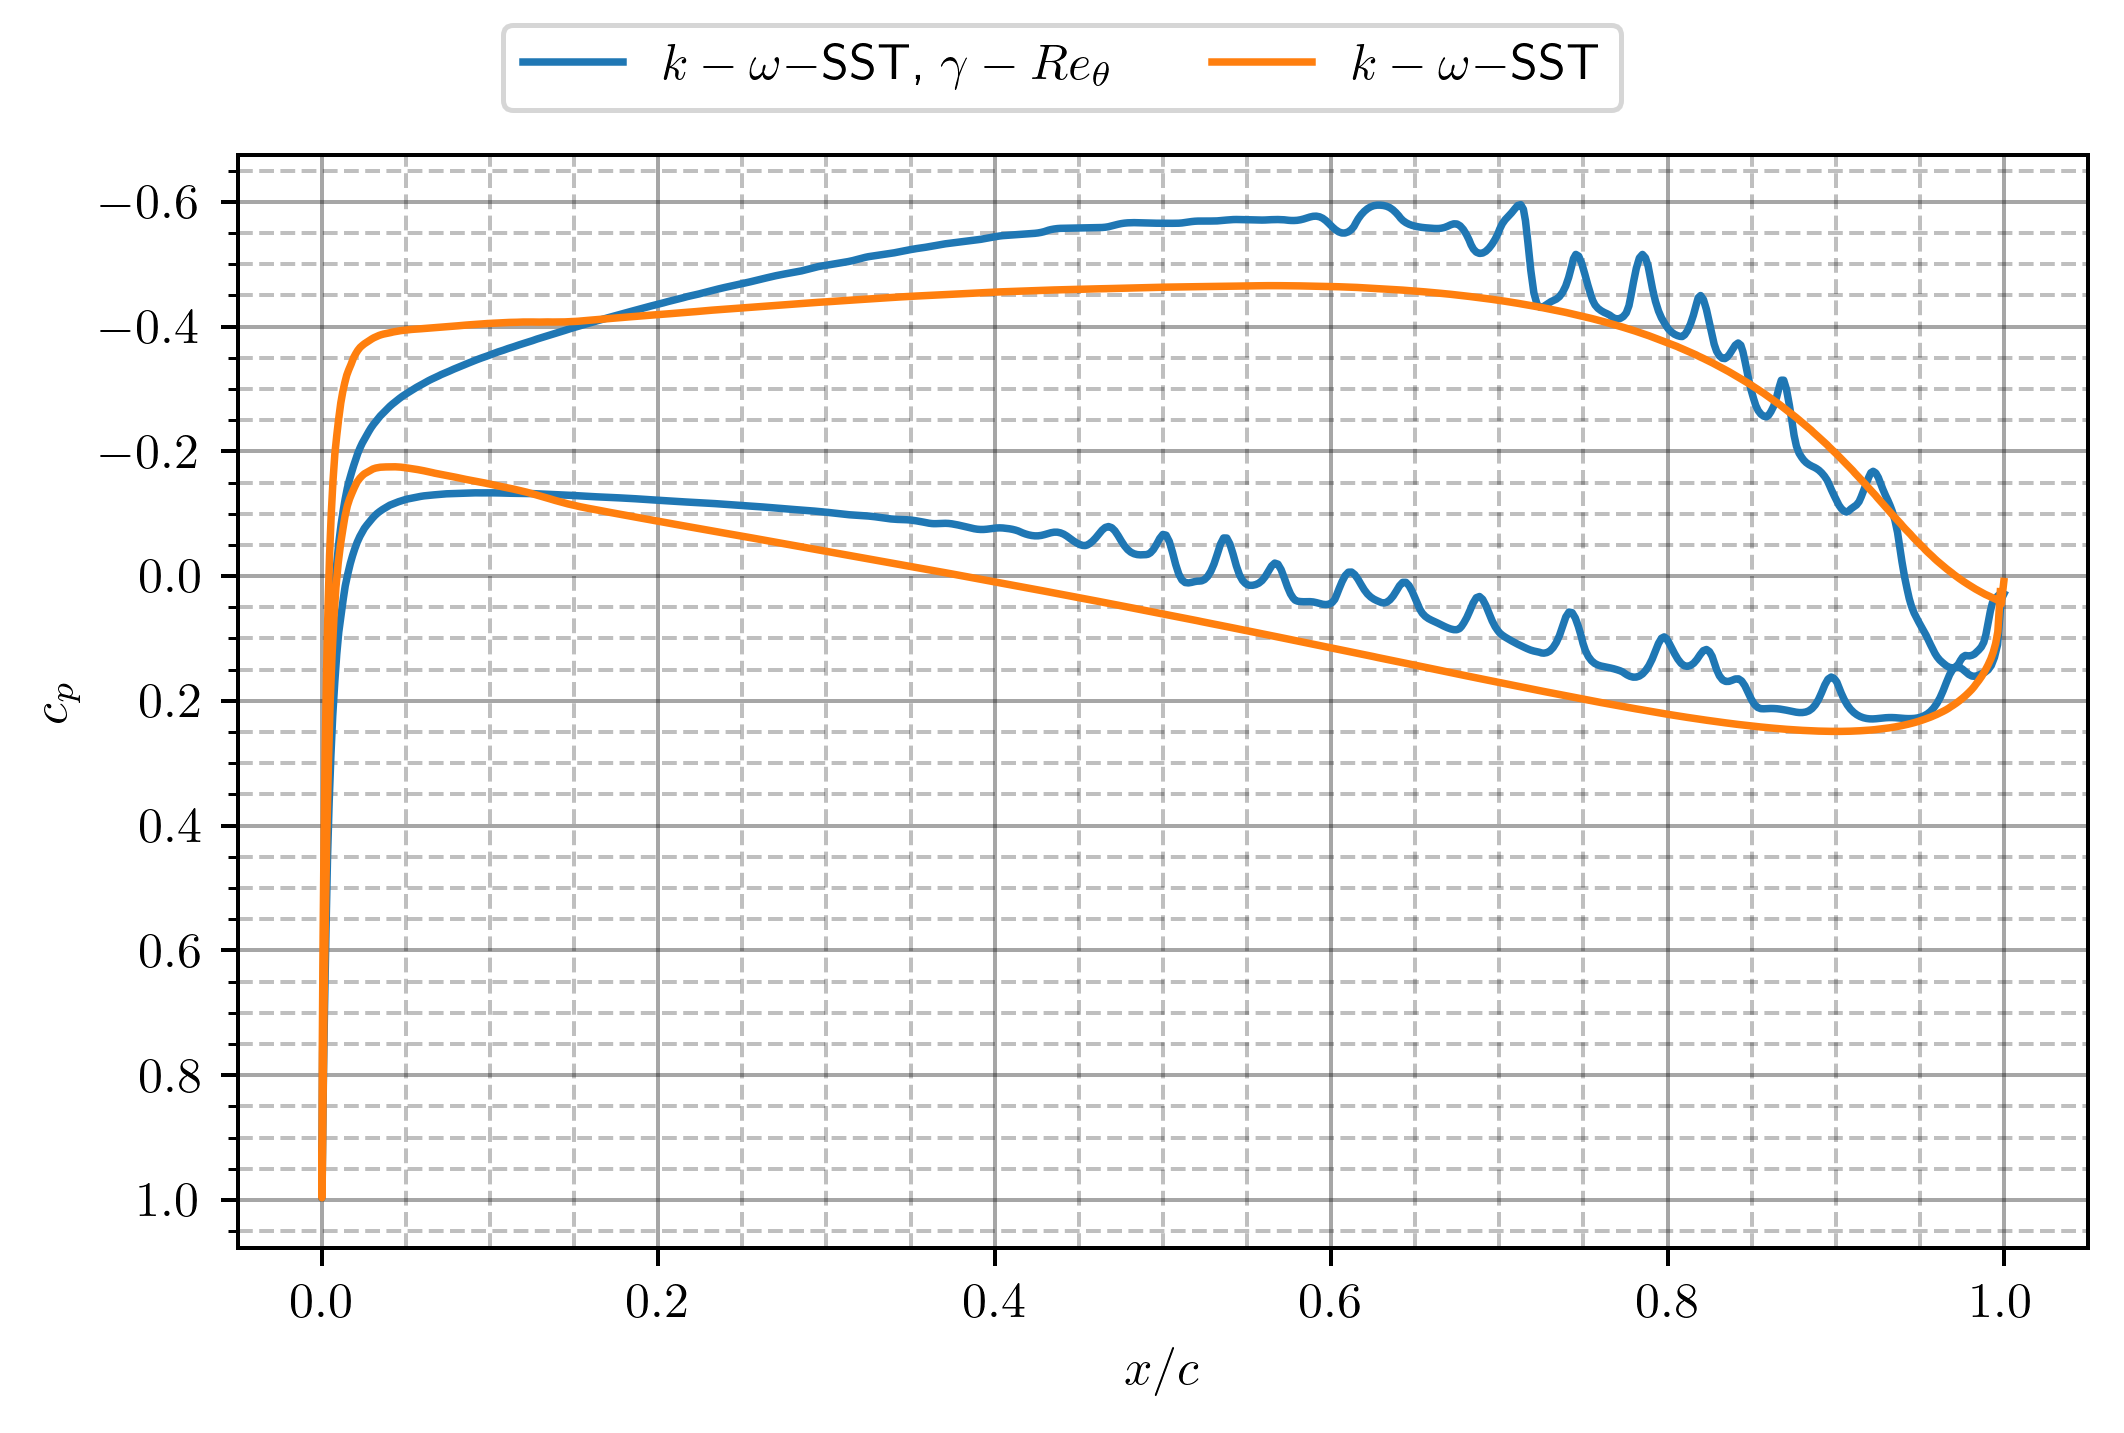

In [12]:
# plot mean cp-distribution
fig, ax = plt.subplots(figsize=(6, 4))
for j in range(len(cases)):
    ax.plot(x[j]/chord, cp[j], zorder=10, color=color[j], label=f"{legend[j]}")
ax.set_xlabel(r"$x/c$")
ax.set_ylabel("$c_p$")
ax.grid(visible=True, which="major", linestyle="-", alpha=0.35, color="black", axis="both")
ax.minorticks_on()
ax.tick_params(axis="x", which="minor", bottom=False)
ax.grid(visible=True, which="minor", linestyle="--", alpha=0.25, color="black", axis="both")
plt.gca().invert_yaxis()
fig.tight_layout()
fig.legend(ncol=3, loc="upper center")
fig.subplots_adjust(top=0.9)
plt.savefig(join(save_dir, f"comparison_cp_distribution_{which_alpha}.png"))

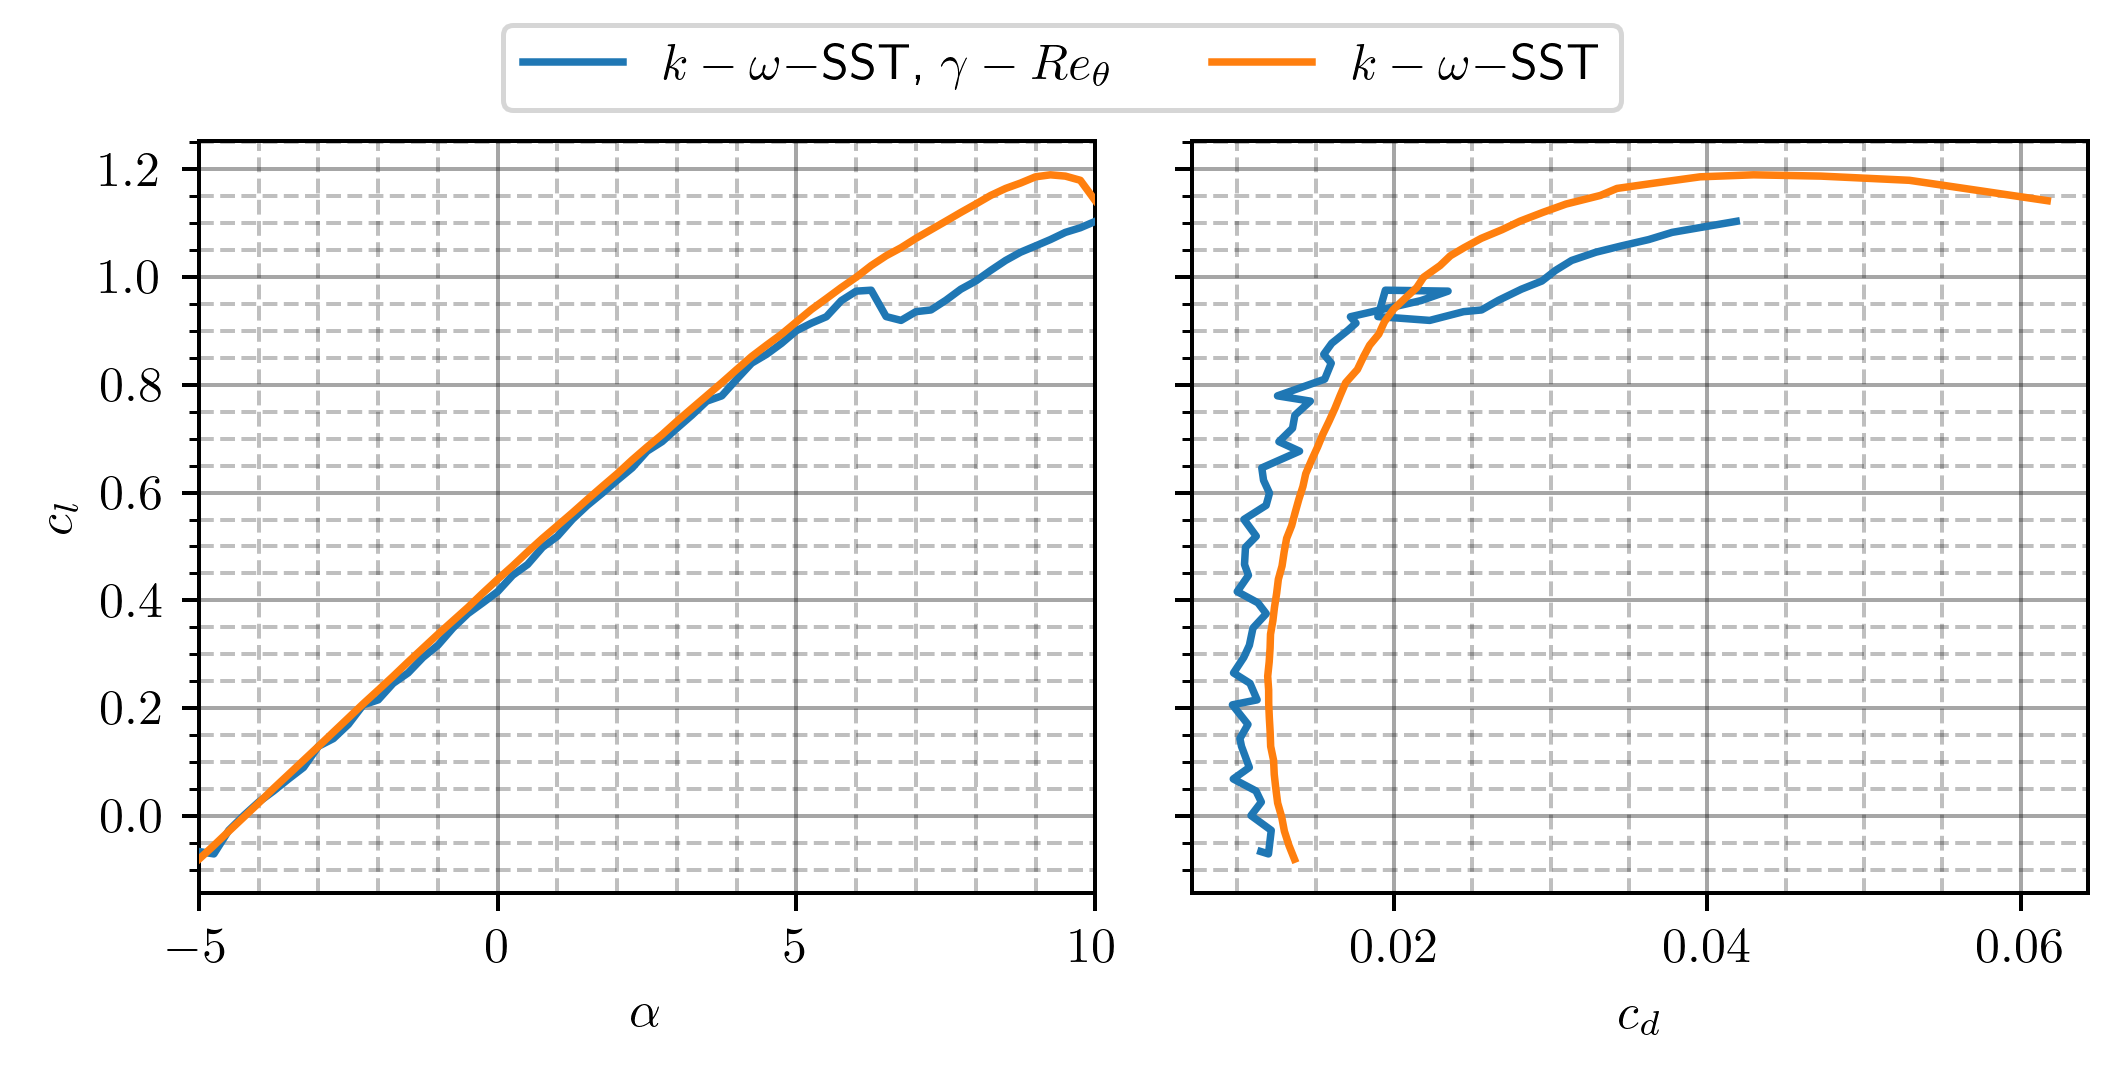

In [13]:
# plot alpha-cl and cd-cl polars for the final airfoil
polar_data = [pd.read_csv(join(load_dir, c, "validation_run", "polar_trial_0.dat"), sep=r"\s+", comment="#", header=None, usecols=[0, 1, 2, 3], 
                         names=["alpha", "cd", "cl", "cm_pitch"], skiprows=2) for c in cases]

fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey="row")
for i, polar in enumerate(polar_data):
    ax[0].plot(polar["alpha"], polar["cl"], label=legend[i], zorder=10)
    ax[1].plot(polar["cd"], polar["cl"], zorder=10)
ax[0].set_xlabel(r"$\alpha$")
ax[1].set_xlabel(r"$c_d$")
ax[0].set_ylabel(r"$c_l$")
ax[0].set_xlim(polar["alpha"].min(), polar["alpha"].max())

for i in range(2):
    ax[i].grid(visible=True, which="major", linestyle="-", alpha=0.35, color="black", axis="both")
    ax[i].minorticks_on()
    ax[i].tick_params(axis="x", which="minor", bottom=False)
    ax[i].grid(visible=True, which="minor", linestyle="--", alpha=0.25, color="black", axis="both")

fig.tight_layout()
fig.legend(ncol=3, loc="upper center")
fig.subplots_adjust(top=0.88)
plt.savefig(join(save_dir, "polar_final_airfoils"))
plt.show()

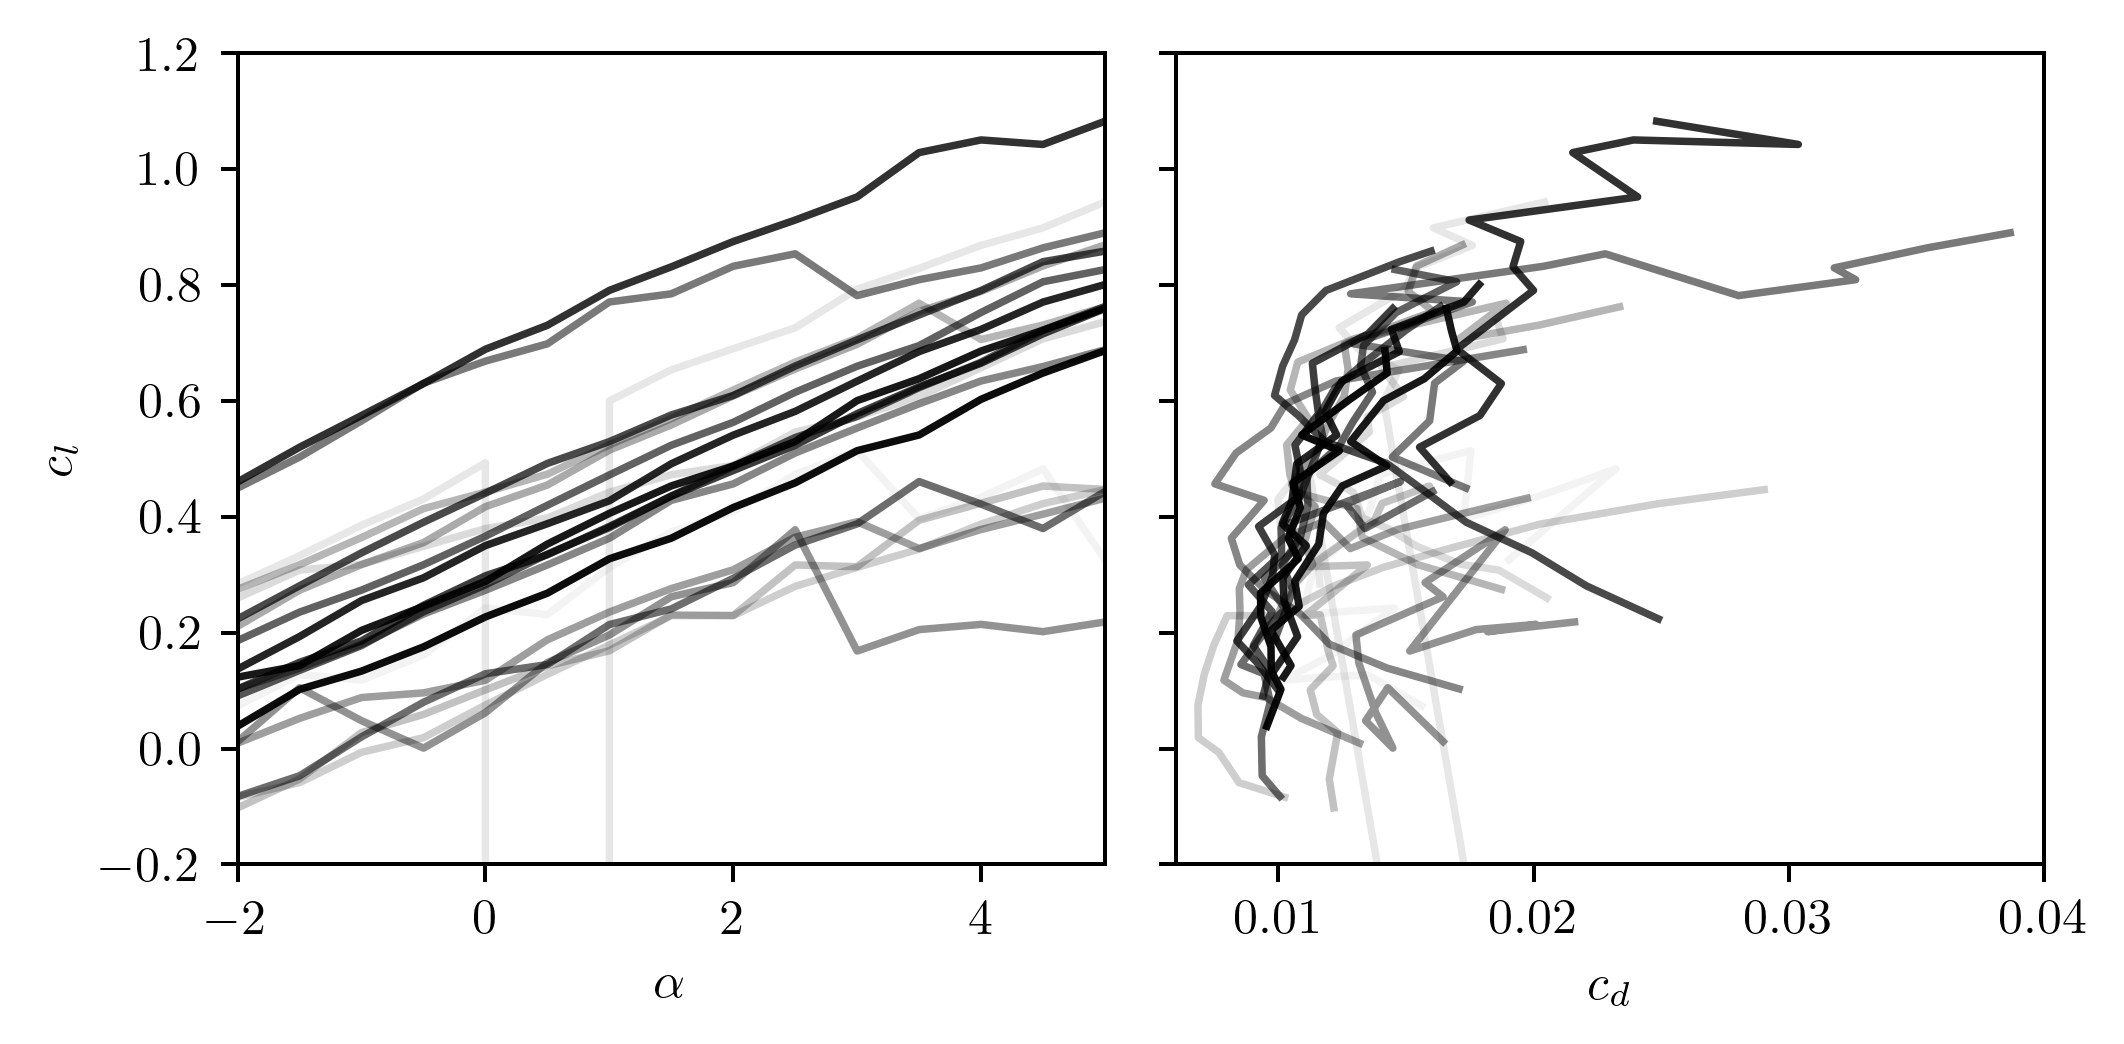

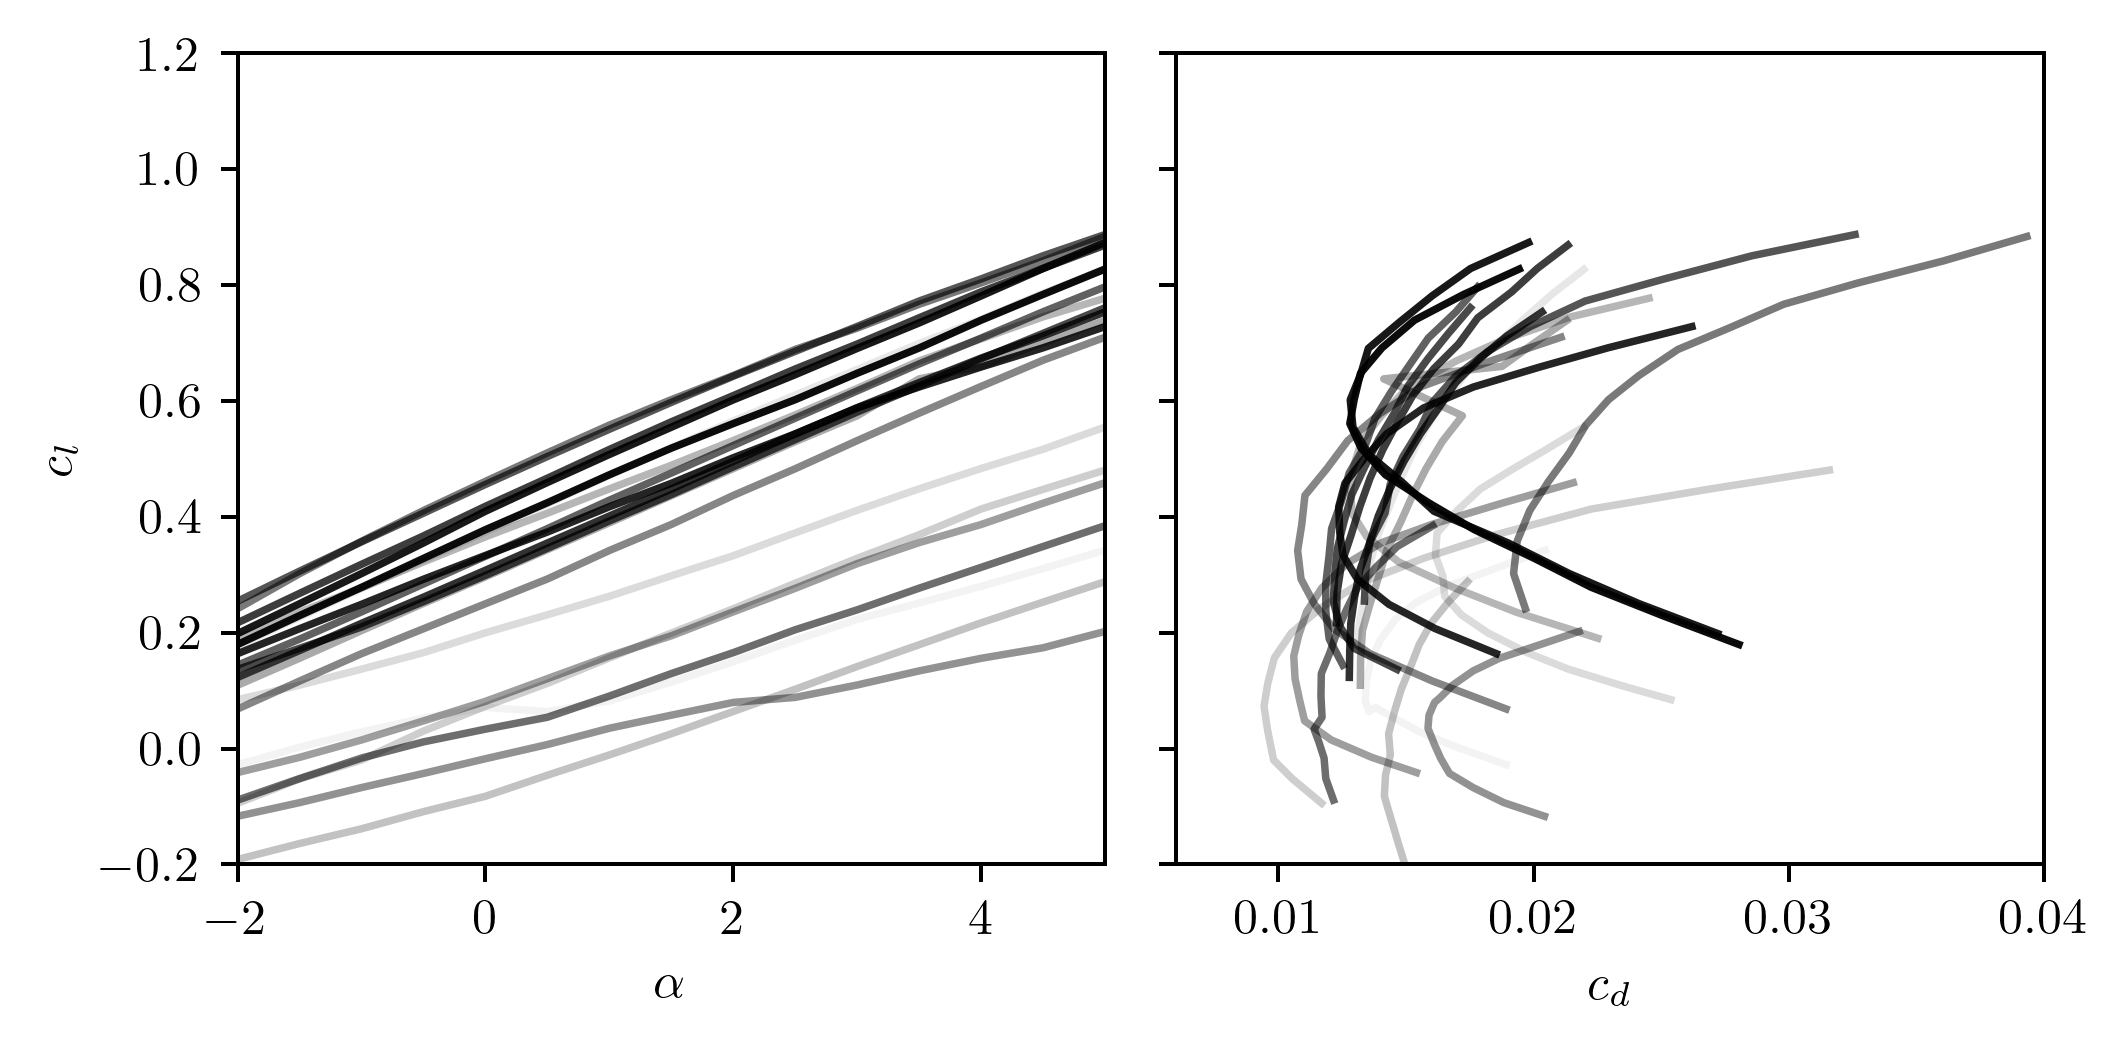

In [14]:
# plot alpha-cl and cd-cl polars during the optimization
polar_data = [load_polar_files(join(load_dir, c)) for c in cases]

for idx, case in enumerate(polar_data):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey="row")
    for i, polar in enumerate(case):
        ax[0].plot(polar["alpha"], polar["cl"], color="black", alpha=(i+1)/(len(case)+1))
        ax[1].plot(polar["cd"], polar["cl"], color="black", alpha=(i+1)/(len(case)+1))
    ax[0].set_xlabel(r"$\alpha$")
    ax[1].set_xlabel(r"$c_d$")
    ax[0].set_ylabel(r"$c_l$")
    ax[1].set_ylim(-0.2, 1.2)
    ax[1].set_xlim(0.006, 0.04)
    ax[0].set_xlim(polar["alpha"].min(), polar["alpha"].max())
    fig.tight_layout()
    plt.savefig(join(save_dir, f"polar_vs_trial_case{idx}"))

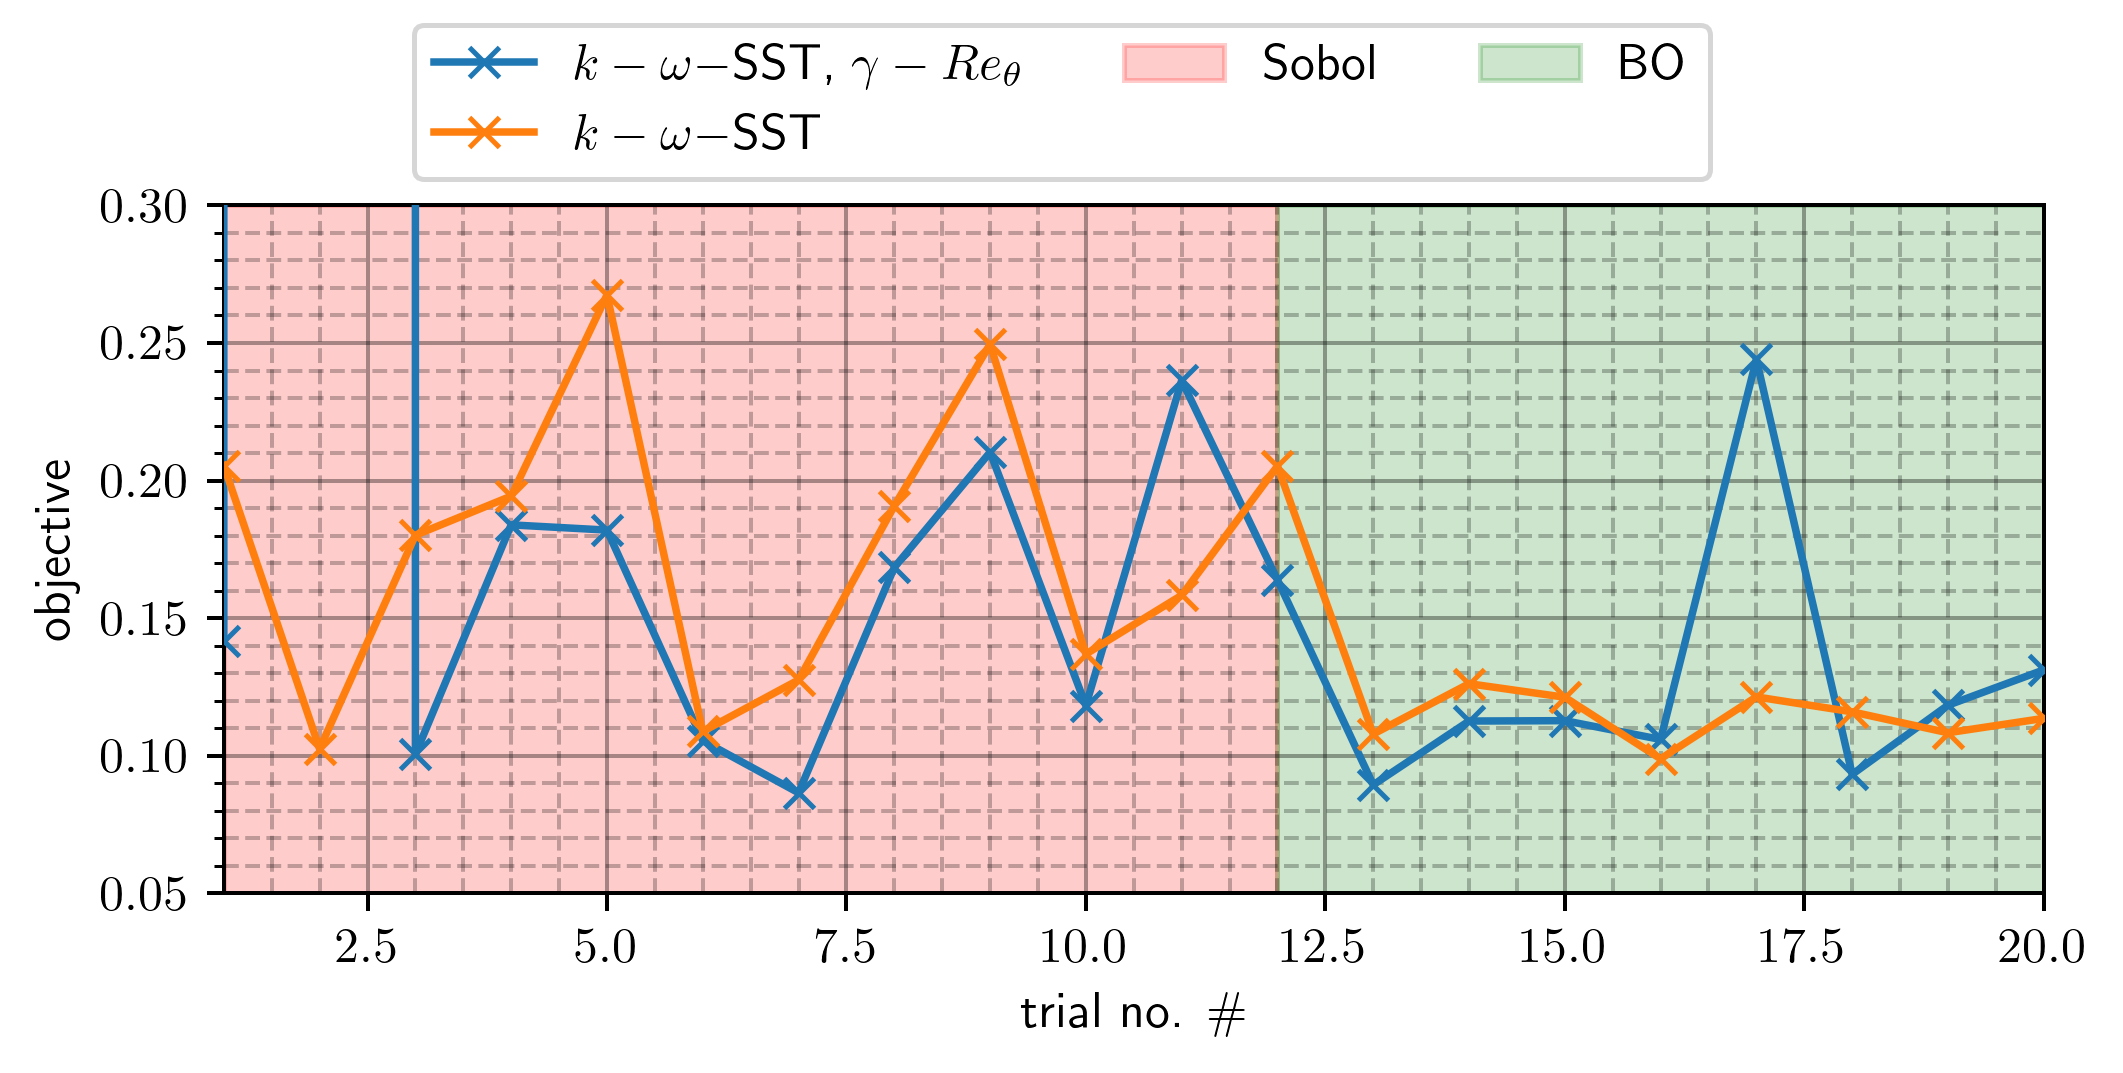

In [19]:
# load the loss vs. trials
log_file = [load_optimization_log(join(load_dir, c)) for c in cases]

n_sobol = 12

# plot the loss vs. trial
fig, ax = plt.subplots(figsize=(6, 3))
for i, l in enumerate(log_file):
    ax.plot(range(1, len(l.objective)+1), l.objective, marker="x", label=legend[i], zorder=10)
ax.set_xlabel(r"trial no. $\#$")
ax.set_xlim(1, len(log_file[0].objective))
ax.set_ylim(0.05, 0.3)
ax.set_ylabel("objective")

# mark Sobol and BO trials
ax.axvspan(1, n_sobol, 0, 1, color="red", alpha=0.2, label="Sobol", zorder=0)
ax.axvspan(n_sobol, len(log_file[0].objective), 0, 1, color="green", alpha=0.2, label="BO", zorder=0)

ax.grid(visible=True, which="major", linestyle="-", alpha=0.35, color="black", axis="both")
ax.minorticks_on()
ax.tick_params(axis="x", which="minor", bottom=False)
ax.grid(visible=True, which="minor", linestyle="--", alpha=0.25, color="black", axis="both")
fig.tight_layout()
fig.legend(ncol=3, loc="upper center")
fig.subplots_adjust(top=0.82)
plt.savefig(join(save_dir, "trial_vs_objective"))

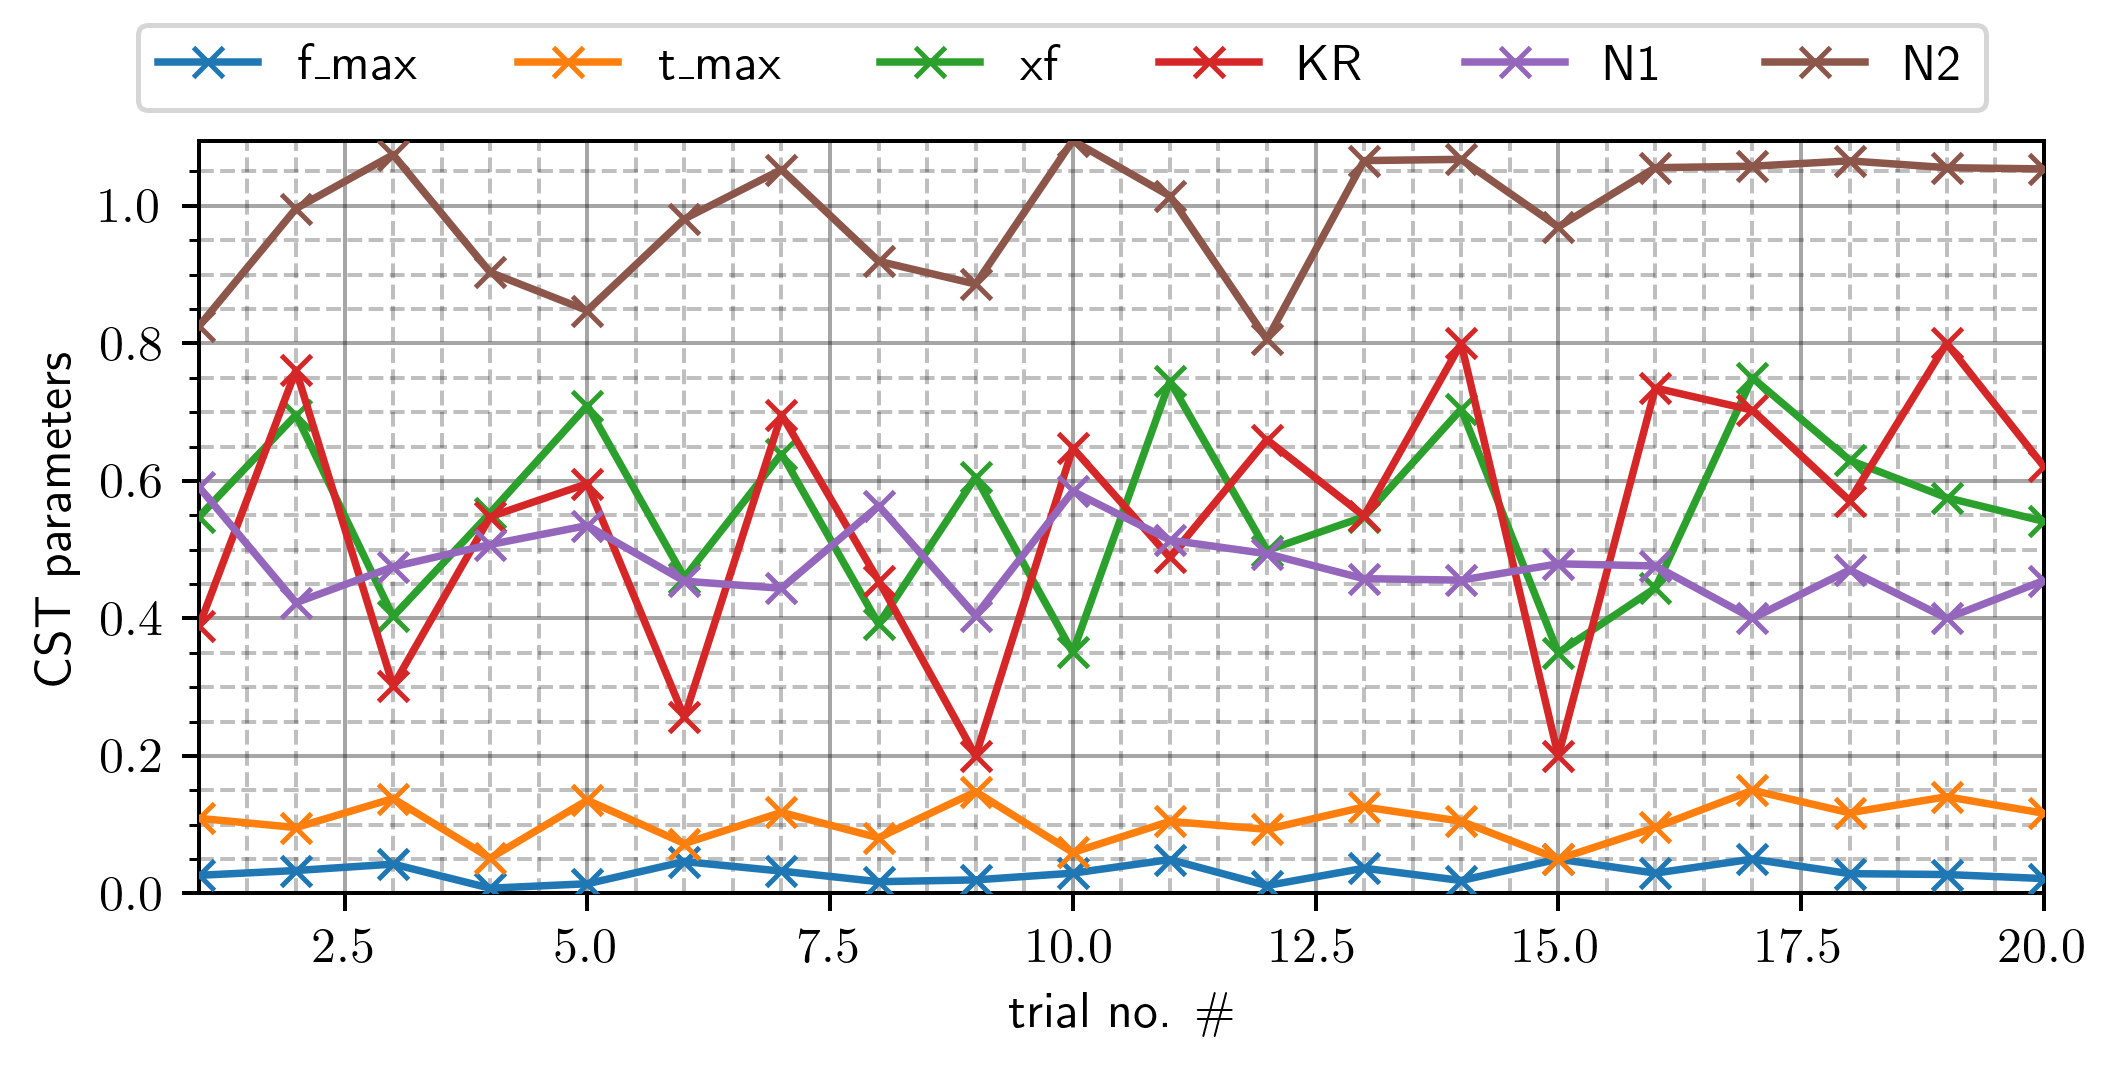

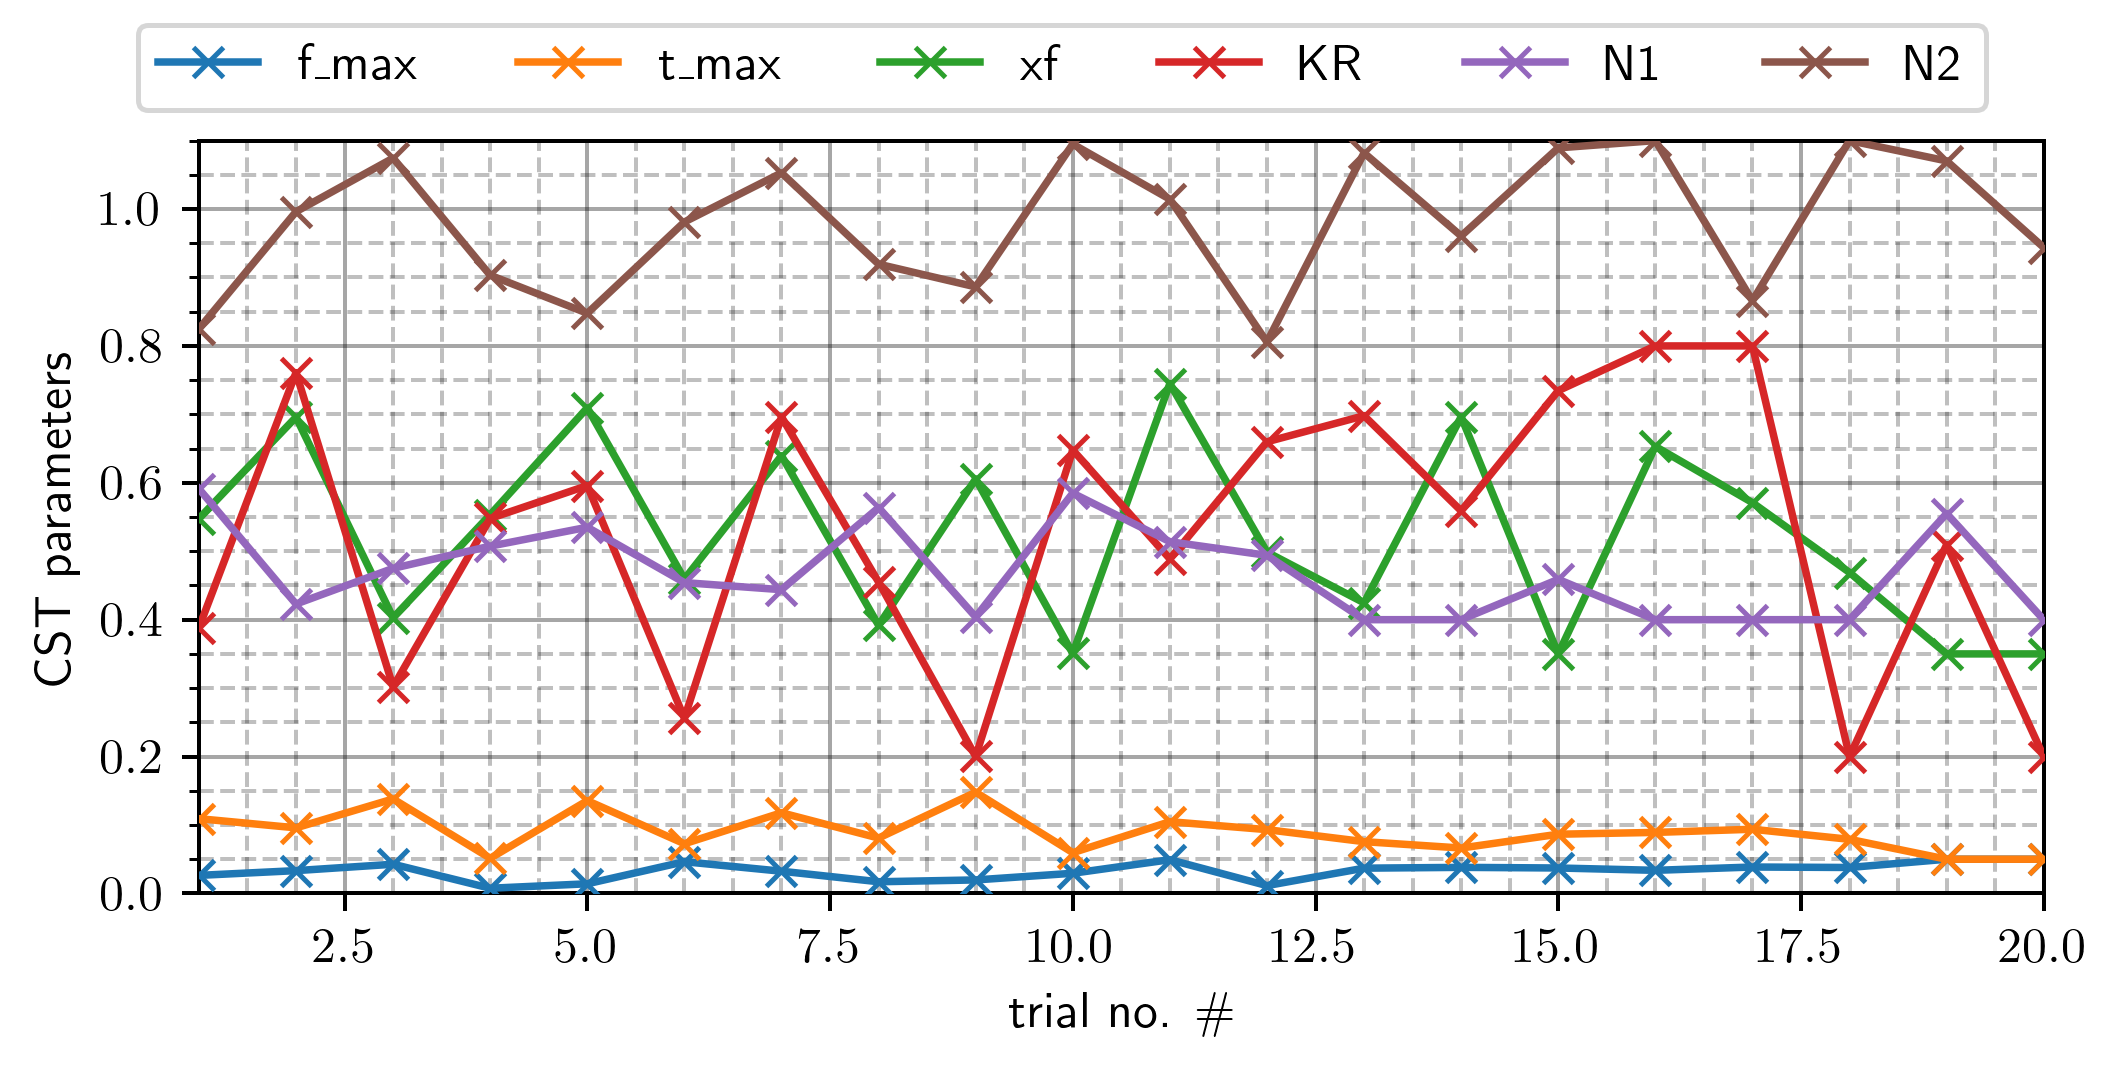

In [21]:
# plot CST parameters vs. trial
for i, l in enumerate(log_file):
    fig, ax = plt.subplots(figsize=(6, 3))
    for k in l.keys():
        if not k == "trial" and not k == "objective":
                ax.plot(range(1, len(l.objective)+1), l[k], marker="x", label=k, zorder=10)
    ax.set_xlabel(r"trial no. $\#$")
    ax.set_xlim(1, len(log_file[i].objective))
    ax.set_ylim(0, max(log_file[i].N2))
    ax.set_ylabel("CST parameters")
    
    ax.grid(visible=True, which="major", linestyle="-", alpha=0.35, color="black", axis="both")
    ax.minorticks_on()
    ax.tick_params(axis="x", which="minor", bottom=False)
    ax.grid(visible=True, which="minor", linestyle="--", alpha=0.25, color="black", axis="both")
    fig.tight_layout()
    fig.legend(ncol=6, loc="upper center")
    fig.subplots_adjust(top=0.88)
    plt.savefig(join(save_dir, f"CST_parameters_vs_objective_case{i}"))